# Import File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
TEST_SIZE = 0.8

In [2]:
data_path = 'data/hdb_latest.csv'

In [3]:
df_combined_geo = pd.read_csv(data_path)

C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\2287234153.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined_geo = pd.read_csv(data_path)


## Feature Engineering

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# we can drop id and lease commence date 
# lease commence date since the feature is already present in remaining lease

In [6]:
# make a copy first
df_original = df_combined_geo.copy()

In [7]:
train_df, test_df = train_test_split(df_combined_geo, test_size=TEST_SIZE, random_state=SEED)

In [8]:
train_df.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')

In [9]:
train_df.head()

town  flat_type      flat_model  floor_area_sqm  \
76365   JURONG EAST     4 ROOM  New Generation           103.0   
473179      HOUGANG     5 ROOM        Improved           121.0   
445613    WOODLANDS     4 ROOM         Model A           101.0   
817033    WOODLANDS  EXECUTIVE      MAISONETTE           146.0   
277677       YISHUN     3 ROOM         Model A            74.0   

              street_name  resale_price    month  lease_commence_date  \
76365       TEBAN GDNS RD      395000.0  2021-03                 1981   
473179      HOUGANG AVE 9      265000.0  2006-09                 1999   
445613  WOODLANDS RING RD      208000.0  2002-07                 1998   
817033    WOODLANDS ST 81      430000.0  1998-04                 1988   
277677     YISHUN RING RD      223000.0  2009-09                 1983   

       storey_range block     remaining_lease                address  \
76365      10 TO 12    31  59 years 04 months       31 TEBAN GDNS RD   
473179     01 TO 03   964                  92      964 HOUGANG AVE 9   
445613     07 TO 09   644                  95  644 WOODLANDS RING RD   
817033     04 TO 06   804                  89    804 WOODLANDS ST 81   
277677     07 TO 09   115                  73     115 YISHUN RING RD   

                                             full_address       lat  \
76365              31 TEBAN GARDENS ROAD SINGAPORE 600031  1.320308   
473179              964 HOUGANG AVENUE 9 SINGAPORE 530964  1.377158   
445613           644 WOODLANDS RING ROAD SINGAPORE 730644  1.436909   
817033           804 WOODLANDS STREET 81 SINGAPORE 730804  1.439970   
277677  115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...  1.434565   

              long  nearest_mrt  nearest_distance_to_mrt  
76365   103.738968  jurong east                    1.475  
473179  103.877524     tongkang                    1.641  
445613  103.801599    admiralty                    0.415  
817033  103.787772    woodlands                    0.398  
277677  103.827974     canberra                    0.966

In [10]:
# Lease commence date has already been processed with current date.
# Address is a combination of block and street name. The Full address is retrieved from onemap sg using address.
train_df.drop(columns=['lease_commence_date','street_name','block','address'], inplace=True)

In [11]:
train_df['remaining_lease'].astype(str).str[:2].astype(int)

76365     59
473179    92
445613    95
817033    89
277677    73
          ..
259178    65
365838    75
131932    95
671155    78
121958    51
Name: remaining_lease, Length: 176039, dtype: int32

In [12]:
# Conversion
train_df['remaining_lease'] = train_df['remaining_lease'].astype(str).str[:2].astype(int)
train_df['floor_area_sqm'] = train_df['floor_area_sqm'].astype(float)
train_df['resale_price'] = train_df['resale_price'].astype(float)


In [13]:
# Add year and convert month into actual months
train_df['year'] = pd.to_datetime(train_df['month']).dt.year
train_df['month'] = pd.to_datetime(train_df['month']).dt.month

### Adding District Number 

The district number is part of the postal code which is a cluster of properties that are near each other

https://en.wikipedia.org/wiki/Postal_codes_in_Singapore <br>
https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm

In [14]:
train_df['district'] = train_df['full_address'].apply(lambda x:x[-6:-4])

In [15]:
# there are some full addresses that do not have postal codes at the back
train_df['district'] = pd.to_numeric(train_df['district'], errors='coerce')

In [16]:
train_df[train_df['district'].isna()==True]

town  flat_type      flat_model  floor_area_sqm  \
354197        HOUGANG     3 ROOM         Model A            74.0   
844619  CHOA CHU KANG     4 ROOM         MODEL A           104.0   
716662        HOUGANG     3 ROOM         MODEL A            92.0   
67876         HOUGANG     4 ROOM         Model A           103.0   
186457    JURONG EAST     3 ROOM  New Generation            82.0   
...               ...        ...             ...             ...   
481719      WOODLANDS     4 ROOM         Model A           101.0   
110155       TAMPINES     3 ROOM  New Generation            73.0   
203502      SERANGOON     5 ROOM   Adjoined flat           137.0   
865962      WOODLANDS  EXECUTIVE       APARTMENT           162.0   
830460         YISHUN  EXECUTIVE      MAISONETTE           146.0   

        resale_price  month storey_range  remaining_lease  \
354197      383000.0      2     01 TO 03               69   
844619      268000.0     12     07 TO 09               91   
716662      153000.0      4     01 TO 03               88   
67876       435000.0      2     10 TO 12               70   
186457      178000.0      5     07 TO 09               73   
...              ...    ...          ...              ...   
481719      287000.0     10     07 TO 09               91   
110155      228000.0      4     01 TO 03               76   
203502      490000.0      5     10 TO 12               73   
865962      535000.0     10     01 TO 03               95   
830460      460000.0     10     07 TO 09               89   

                                 full_address       lat        long  \
354197                  210 HOUGANG STREET 21  1.359464  103.886861   
844619  BLK 216 AND 215 CHOA CHU KANG CENTRAL  1.383083  103.747077   
716662                  210 HOUGANG STREET 21  1.359464  103.886861   
67876                    435 HOUGANG AVENUE 8  1.377527  103.893597   
186457              229 JURONG EAST STREET 21  1.341837  103.738021   
...                                       ...       ...         ...   
481719                 539 WOODLANDS DRIVE 16  1.429077  103.792256   
110155                 211 TAMPINES STREET 23  1.354021  103.954843   
203502                      2 LORONG LEW LIAN  1.350577  103.875648   
865962                302 WOODLANDS STREET 31  1.431861  103.774474   
830460                   356 YISHUN RING ROAD  1.425291  103.845454   

             nearest_mrt  nearest_distance_to_mrt  year  district  
354197             kovan                    0.215  2014       NaN  
844619     choa chu kang                    0.393  1998       NaN  
716662        ang mo kio                    4.307  1995       NaN  
67876           buangkok                    0.596  2020       NaN  
186457    chinese garden                    0.606  2007       NaN  
...                  ...                      ...   ...       ...  
481719  woodlands south                     0.218  2008       NaN  
110155     tampines east                    0.242  2008       NaN  
203502         serangoon                    0.250  2009       NaN  
865962         marsiling                    0.086  1997       NaN  
830460            yishun                    1.250  1998       NaN  

[331 rows x 15 columns]

In [17]:
train_df.fillna(0,axis=0, inplace=True)

In [18]:
count = 0 
dont_repeat_dict = {}
for idx, district in train_df['district'].reset_index().values:
    if district not in dont_repeat_dict:
        try:
            # cast into int
            int(district)
            dont_repeat_dict[district] = idx
        except Exception as e:
            print(f"Unable to convert {district} at {idx} due to {e}")

In [19]:
train_df.head()

town  flat_type      flat_model  floor_area_sqm  resale_price  \
76365   JURONG EAST     4 ROOM  New Generation           103.0      395000.0   
473179      HOUGANG     5 ROOM        Improved           121.0      265000.0   
445613    WOODLANDS     4 ROOM         Model A           101.0      208000.0   
817033    WOODLANDS  EXECUTIVE      MAISONETTE           146.0      430000.0   
277677       YISHUN     3 ROOM         Model A            74.0      223000.0   

        month storey_range  remaining_lease  \
76365       3     10 TO 12               59   
473179      9     01 TO 03               92   
445613      7     07 TO 09               95   
817033      4     04 TO 06               89   
277677      9     07 TO 09               73   

                                             full_address       lat  \
76365              31 TEBAN GARDENS ROAD SINGAPORE 600031  1.320308   
473179              964 HOUGANG AVENUE 9 SINGAPORE 530964  1.377158   
445613           644 WOODLANDS RING ROAD SINGAPORE 730644  1.436909   
817033           804 WOODLANDS STREET 81 SINGAPORE 730804  1.439970   
277677  115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...  1.434565   

              long  nearest_mrt  nearest_distance_to_mrt  year  district  
76365   103.738968  jurong east                    1.475  2021      60.0  
473179  103.877524     tongkang                    1.641  2006      53.0  
445613  103.801599    admiralty                    0.415  2002      73.0  
817033  103.787772    woodlands                    0.398  1998      73.0  
277677  103.827974     canberra                    0.966  2009      76.0

In [20]:
# not all of the full address from the onemap sg contains postal code =(
train_df.reset_index()[train_df.reset_index()['index']==826933]

Empty DataFrame
Columns: [index, town, flat_type, flat_model, floor_area_sqm, resale_price, month, storey_range, remaining_lease, full_address, lat, long, nearest_mrt, nearest_distance_to_mrt, year, district]
Index: []

In [21]:
for district in list(train_df['district'].unique()):
    try:
        # cast into int
        int(district)
    except Exception as e:
        print(f"Unable to convert {district} due to {e}")

# EDA

Questions I want to explore
- Is there a difference pre and post 2000?
  - Distance between MRTs
  - Prices
- What is the most important feature for predicting prices
- How much have price been increasing
- Which district is the most expensive

### Sanity Checks

In [22]:
# Checks whether all addresses have 1 to 1 relationship with the lat and long coordinates
data_path = "data/hdb_latest.csv"
df = pd.read_csv(data_path)
res_lat = df.groupby('address')['lat'].agg([min, max])
res_long = df.groupby('address')['long'].agg([min, max])
assert res_lat['min'].equals(res_lat['max']) == True
assert res_long['min'].equals(res_long['max']) == True

C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\3301805353.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [23]:
# Check for invalids / NAs

In [24]:
# Explicit NAs
train_df.isna().any().all()

False

In [25]:
train_df.describe().T

count           mean            std          min  \
floor_area_sqm           176039.0      96.182404      25.765014    31.000000   
resale_price             176039.0  313436.280883  161972.838180  5000.000000   
month                    176039.0       6.574946       3.409718     1.000000   
remaining_lease          176039.0      81.361596      10.505368    10.000000   
lat                      176039.0       1.362148       0.041490     1.270380   
long                     176039.0     103.839424       0.073761   103.685228   
nearest_distance_to_mrt  176039.0       0.801480       0.690535     0.023000   
year                     176039.0    2005.605974       8.843328  1990.000000   
district                 176039.0      53.536836      18.284552     0.000000   

                                   25%            50%            75%  \
floor_area_sqm               73.000000      93.000000     114.000000   
resale_price             192000.000000  290000.000000  406000.000000   
month                         4.000000       7.000000      10.000000   
remaining_lease              75.000000      83.000000      90.000000   
lat                           1.334393       1.355159       1.382230   
long                        103.773300     103.843118     103.898075   
nearest_distance_to_mrt       0.408000       0.649000       0.964000   
year                       1998.000000    2004.000000    2012.000000   
district                     46.000000      55.000000      67.000000   

                                  max  
floor_area_sqm           2.660000e+02  
resale_price             1.380000e+06  
month                    1.200000e+01  
remaining_lease          9.900000e+01  
lat                      1.457071e+00  
long                     1.039875e+02  
nearest_distance_to_mrt  5.530000e+00  
year                     2.023000e+03  
district                 8.200000e+01

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176039 entries, 76365 to 121958
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   town                     176039 non-null  object 
 1   flat_type                176039 non-null  object 
 2   flat_model               176039 non-null  object 
 3   floor_area_sqm           176039 non-null  float64
 4   resale_price             176039 non-null  float64
 5   month                    176039 non-null  int64  
 6   storey_range             176039 non-null  object 
 7   remaining_lease          176039 non-null  int32  
 8   full_address             176039 non-null  object 
 9   lat                      176039 non-null  float64
 10  long                     176039 non-null  float64
 11  nearest_mrt              176039 non-null  object 
 12  nearest_distance_to_mrt  176039 non-null  float64
 13  year                     176039 non-null  int64  
 14  

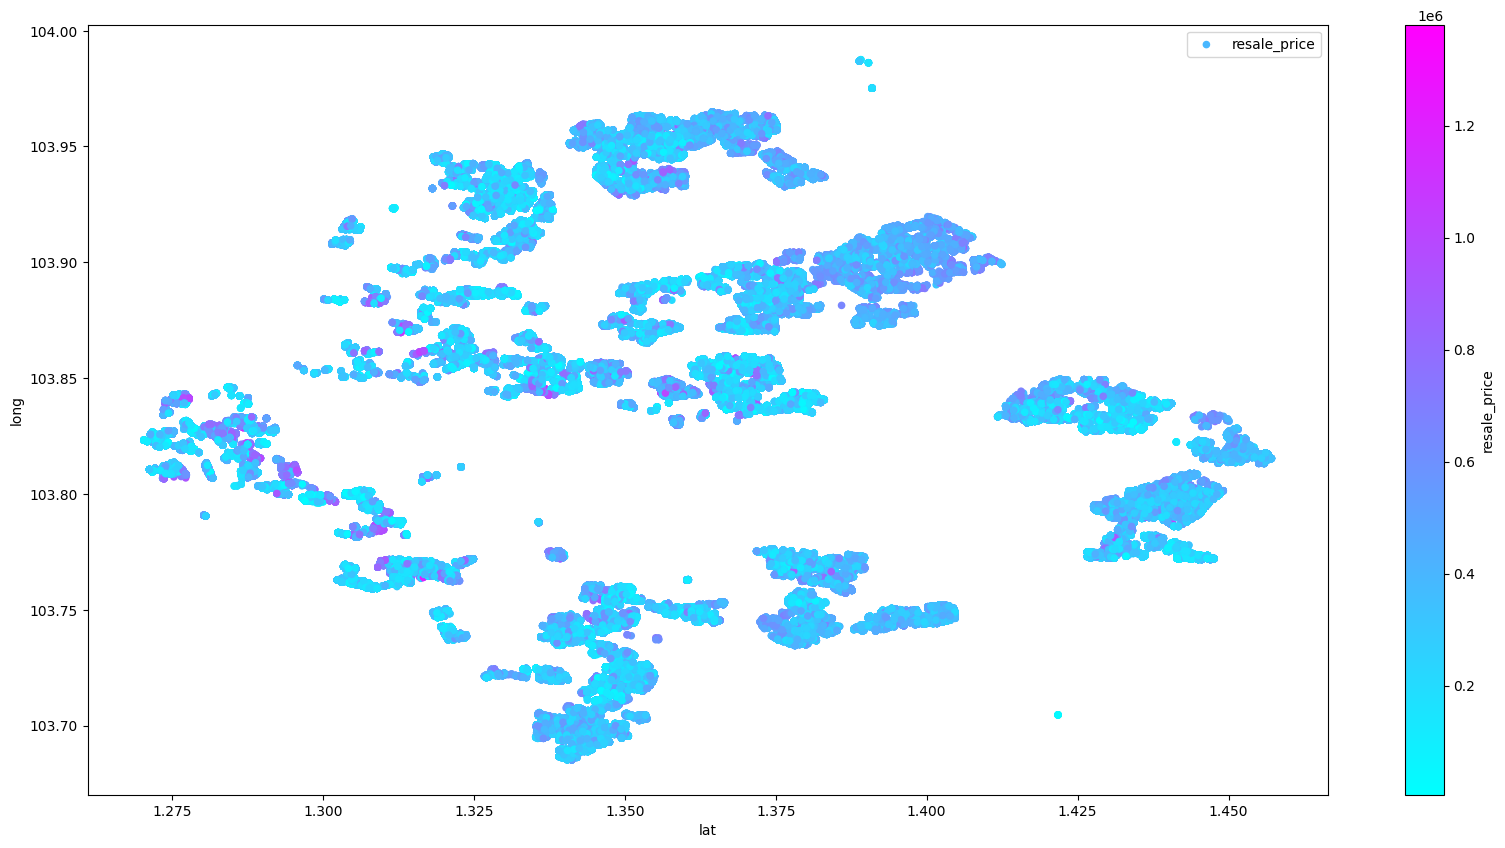

In [27]:
train_df.plot(kind='scatter', 
                x = 'lat', 
                y= 'long', 
                c ='resale_price', 
                label= 'resale_price', 
                cmap = 'cool',
                colorbar = True,
                figsize = (20,10))
plt.show()

<AxesSubplot: >

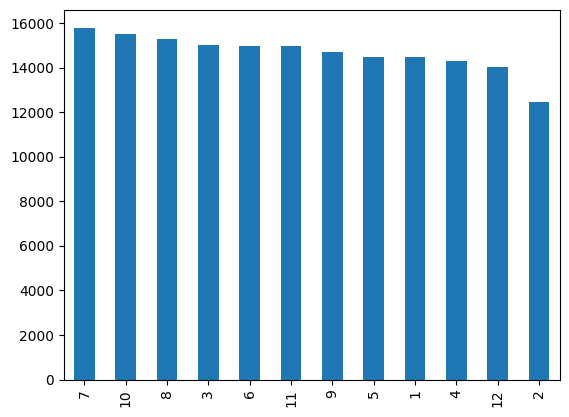

In [28]:
train_df['month'].value_counts().plot(kind= 'bar')

array([[<AxesSubplot: title={'center': 'floor_area_sqm'}>,
        <AxesSubplot: title={'center': 'resale_price'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'remaining_lease'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'long'}>],
       [<AxesSubplot: title={'center': 'nearest_distance_to_mrt'}>,
        <AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'district'}>]], dtype=object)

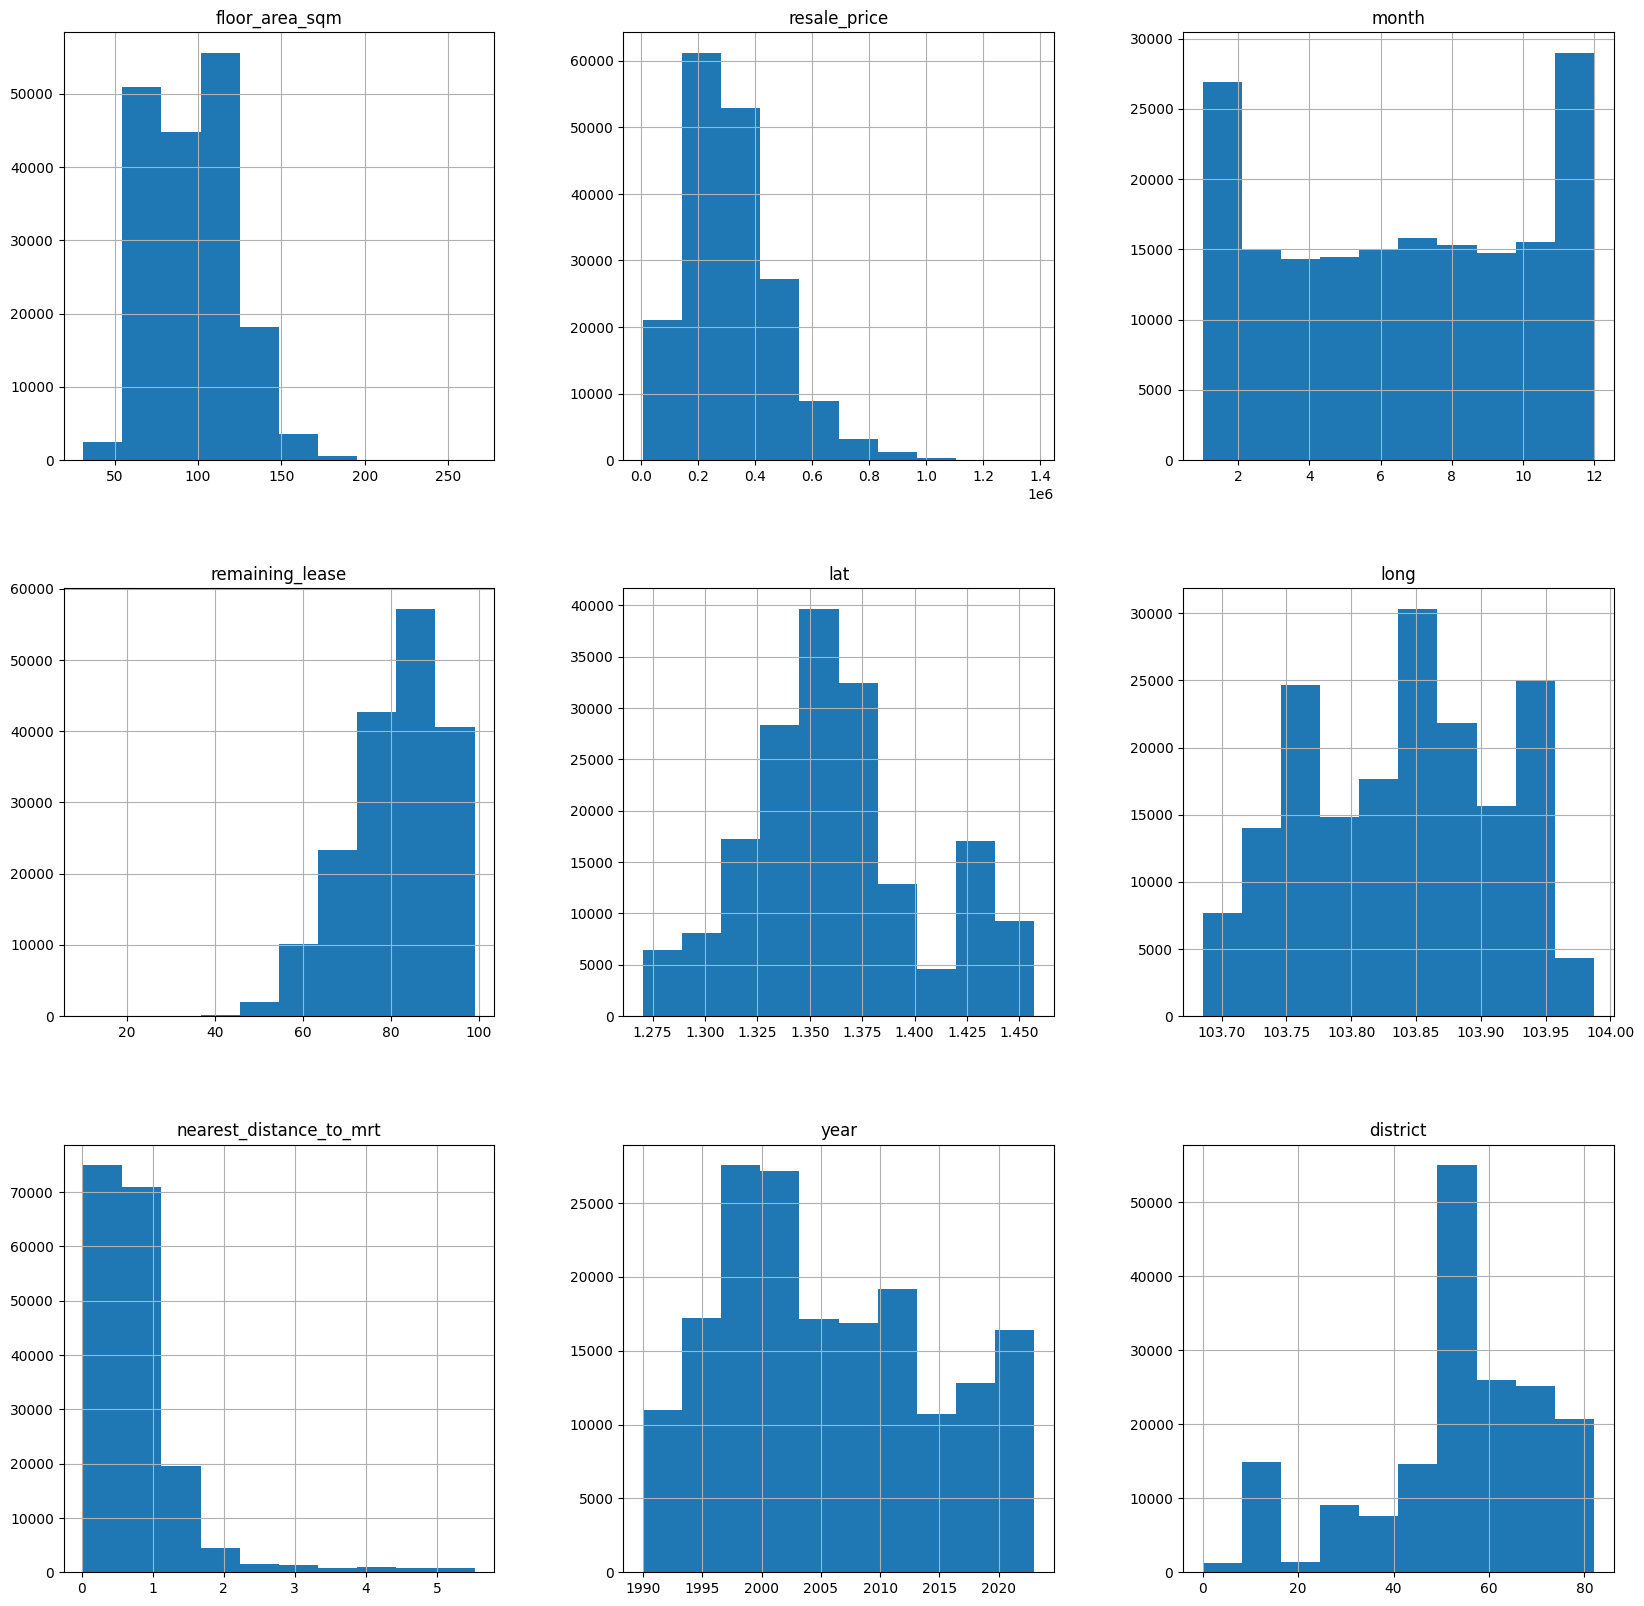

In [29]:
train_df.hist(figsize=(20,20))

Q1 : Is there a difference pre and post 2000 say distance between MRTs and or Prices

In [30]:
post2000_train_df = train_df[train_df['year']>= 2000]
pre2000_train_df = train_df[train_df['year']< 2000]

In [31]:
train_df['year'].value_counts().agg(['idxmax', 'max'])

idxmax     1999
max       11347
Name: year, dtype: int64

In [32]:
train_df.groupby('year').agg('count').iloc[:,[1]]

flat_type
year           
1990       2320
1991       2400
1992       2747
1993       3517
1994       5079
1995       5413
1996       6743
1997       6249
1998       9986
1999      11347
2000       6780
2001       7664
2002       7194
2003       5539
2004       5778
2005       5955
2006       5403
2007       5395
2008       5422
2009       6046
2010       6905
2011       4352
2012       4695
2013       3220
2014       3220
2015       3532
2016       3962
2017       4037
2018       4391
2019       4358
2020       4566
2021       5858
2022       5286
2023        680

In [33]:
year_most_transactions = train_df['year'].value_counts().idxmax()

In [34]:
train_df

town  flat_type      flat_model  floor_area_sqm  \
76365       JURONG EAST     4 ROOM  New Generation           103.0   
473179          HOUGANG     5 ROOM        Improved           121.0   
445613        WOODLANDS     4 ROOM         Model A           101.0   
817033        WOODLANDS  EXECUTIVE      MAISONETTE           146.0   
277677           YISHUN     3 ROOM         Model A            74.0   
...                 ...        ...             ...             ...   
259178  KALLANG/WHAMPOA     3 ROOM        Improved            76.0   
365838      BUKIT MERAH     3 ROOM  New Generation            67.0   
131932        WOODLANDS     4 ROOM         Model A           105.0   
671155        TOA PAYOH     3 ROOM        IMPROVED            65.0   
121958        TOA PAYOH     3 ROOM        Improved            68.0   

        resale_price  month storey_range  remaining_lease  \
76365       395000.0      3     10 TO 12               59   
473179      265000.0      9     01 TO 03               92   
445613      208000.0      7     07 TO 09               95   
817033      430000.0      4     04 TO 06               89   
277677      223000.0      9     07 TO 09               73   
...              ...    ...          ...              ...   
259178      320000.0      7     13 TO 15               65   
365838      158000.0     10     13 TO 15               75   
131932      242000.0      9     07 TO 09               95   
671155      203000.0      5     07 TO 09               78   
121958      298000.0      5     07 TO 09               51   

                                             full_address       lat  \
76365              31 TEBAN GARDENS ROAD SINGAPORE 600031  1.320308   
473179              964 HOUGANG AVENUE 9 SINGAPORE 530964  1.377158   
445613           644 WOODLANDS RING ROAD SINGAPORE 730644  1.436909   
817033           804 WOODLANDS STREET 81 SINGAPORE 730804  1.439970   
277677  115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...  1.434565   
...                                                   ...       ...   
259178  16 UPPER BOON KENG ROAD BOON KENG VILLE SINGAP...  1.315432   
365838  77 TELOK BLANGAH DRIVE DBS TELOK BLANGAH DRIVE...  1.273954   
131932            878 WOODLANDS AVENUE 9 SINGAPORE 730878  1.445433   
671155  232 LORONG 8 TOA PAYOH PCF SPARKLETOTS PRESCHO...  1.337572   
121958            85A LORONG 4 TOA PAYOH SINGAPORE 311085  1.336285   

              long       nearest_mrt  nearest_distance_to_mrt  year  district  
76365   103.738968       jurong east                    1.475  2021      60.0  
473179  103.877524          tongkang                    1.641  2006      53.0  
445613  103.801599         admiralty                    0.415  2002      73.0  
817033  103.787772         woodlands                    0.398  1998      73.0  
277677  103.827974          canberra                    0.966  2009      76.0  
...            ...               ...                      ...   ...       ...  
259178  103.871652           kallang                    0.439  2009      38.0  
365838  103.808817     telok blangah                    0.376  2002      10.0  
131932  103.791997  woodlands north                     0.770  2000      73.0  
671155  103.858844         toa payoh                    1.375  1997      31.0  
121958  103.849406         toa payoh                    0.458  2019      31.0  

[176039 rows x 15 columns]

In [35]:
train_df[train_df['nearest_distance_to_mrt']>5].groupby('year').agg('count').iloc[:,[1]]

flat_type
year           
1990         26
1991         44
1992         32
1993         33
1994         58
1995         64
1996         74
1997        108
1998        153
1999        137

In [36]:
train_df[train_df['nearest_distance_to_mrt']<5].groupby('year').agg('count').iloc[:,[1]]

flat_type
year           
1990       2294
1991       2356
1992       2715
1993       3484
1994       5021
1995       5349
1996       6669
1997       6141
1998       9833
1999      11210
2000       6780
2001       7664
2002       7194
2003       5539
2004       5778
2005       5955
2006       5403
2007       5395
2008       5422
2009       6046
2010       6905
2011       4352
2012       4695
2013       3220
2014       3220
2015       3532
2016       3962
2017       4037
2018       4391
2019       4358
2020       4566
2021       5858
2022       5286
2023        680

In [37]:
df_combined_geo.select_dtypes(include='object').describe().T

count unique  \
town             880195     27   
flat_type        880195      8   
flat_model       880195     34   
street_name      880195    568   
month            880195    398   
storey_range     880195     25   
block            880195   2658   
remaining_lease  880195    748   
address          880195   9576   
full_address     880195   9571   
nearest_mrt      880195    138   

                                                               top    freq  
town                                                      TAMPINES   77728  
flat_type                                                   4 ROOM  336304  
flat_model                                                 Model A  180894  
street_name                                         YISHUN RING RD   17120  
month                                                      1999-03    6334  
storey_range                                              04 TO 06  221581  
block                                                            2    4414  
remaining_lease                                                 95   26869  
address                                            211 BOON LAY PL     808  
full_address     211 BOON LAY PLACE BOON LAY PLACE SINGAPORE 64...     808  
nearest_mrt                                             ang mo kio   50838

In [38]:
df_combined_geo['flat_model'].unique()

array(['Improved', 'Adjoined flat', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Maisonette', 'Model A-Maisonette',
       'Simplified', 'Multi Generation', 'Premium Apartment', 'Terrace',
       '2-room', 'Improved-Maisonette', 'Premium Maisonette', 'Model A2',
       'DBSS', 'Type S1', 'Type S2', 'Premium Apartment Loft', '3Gen',
       'NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', '2-ROOM',
       'TERRACE', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT'], dtype=object)

In [39]:
df_combined_geo['flat_type'].unique()

array(['3 ROOM', '2 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION', '1 ROOM', 'MULTI GENERATION'], dtype=object)

In [40]:
df_combined_geo['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'GEYLANG', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA',
       'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG', 'JURONG EAST', 'YISHUN',
       'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS',
       'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS',
       'SEMBAWANG', 'SENGKANG', 'PUNGGOL', 'LIM CHU KANG'], dtype=object)

In [41]:
df_combined_geo['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '01 TO 05',
       '06 TO 10', '13 TO 15', '11 TO 15', '22 TO 24', '19 TO 21',
       '16 TO 18', '25 TO 27', '21 TO 25', '16 TO 20', '28 TO 30',
       '26 TO 30', '31 TO 33', '37 TO 39', '34 TO 36', '40 TO 42',
       '31 TO 35', '36 TO 40', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

[Text(0, 0, 'JURONG EAST'),
 Text(1, 0, 'HOUGANG'),
 Text(2, 0, 'WOODLANDS'),
 Text(3, 0, 'YISHUN'),
 Text(4, 0, 'SERANGOON'),
 Text(5, 0, 'ANG MO KIO'),
 Text(6, 0, 'CHOA CHU KANG'),
 Text(7, 0, 'PUNGGOL'),
 Text(8, 0, 'QUEENSTOWN'),
 Text(9, 0, 'GEYLANG'),
 Text(10, 0, 'SENGKANG'),
 Text(11, 0, 'PASIR RIS'),
 Text(12, 0, 'TAMPINES'),
 Text(13, 0, 'JURONG WEST'),
 Text(14, 0, 'TOA PAYOH'),
 Text(15, 0, 'BUKIT TIMAH'),
 Text(16, 0, 'KALLANG/WHAMPOA'),
 Text(17, 0, 'BUKIT BATOK'),
 Text(18, 0, 'BISHAN'),
 Text(19, 0, 'BUKIT PANJANG'),
 Text(20, 0, 'BEDOK'),
 Text(21, 0, 'SEMBAWANG'),
 Text(22, 0, 'BUKIT MERAH'),
 Text(23, 0, 'CLEMENTI'),
 Text(24, 0, 'CENTRAL AREA'),
 Text(25, 0, 'MARINE PARADE'),
 Text(26, 0, 'LIM CHU KANG')]

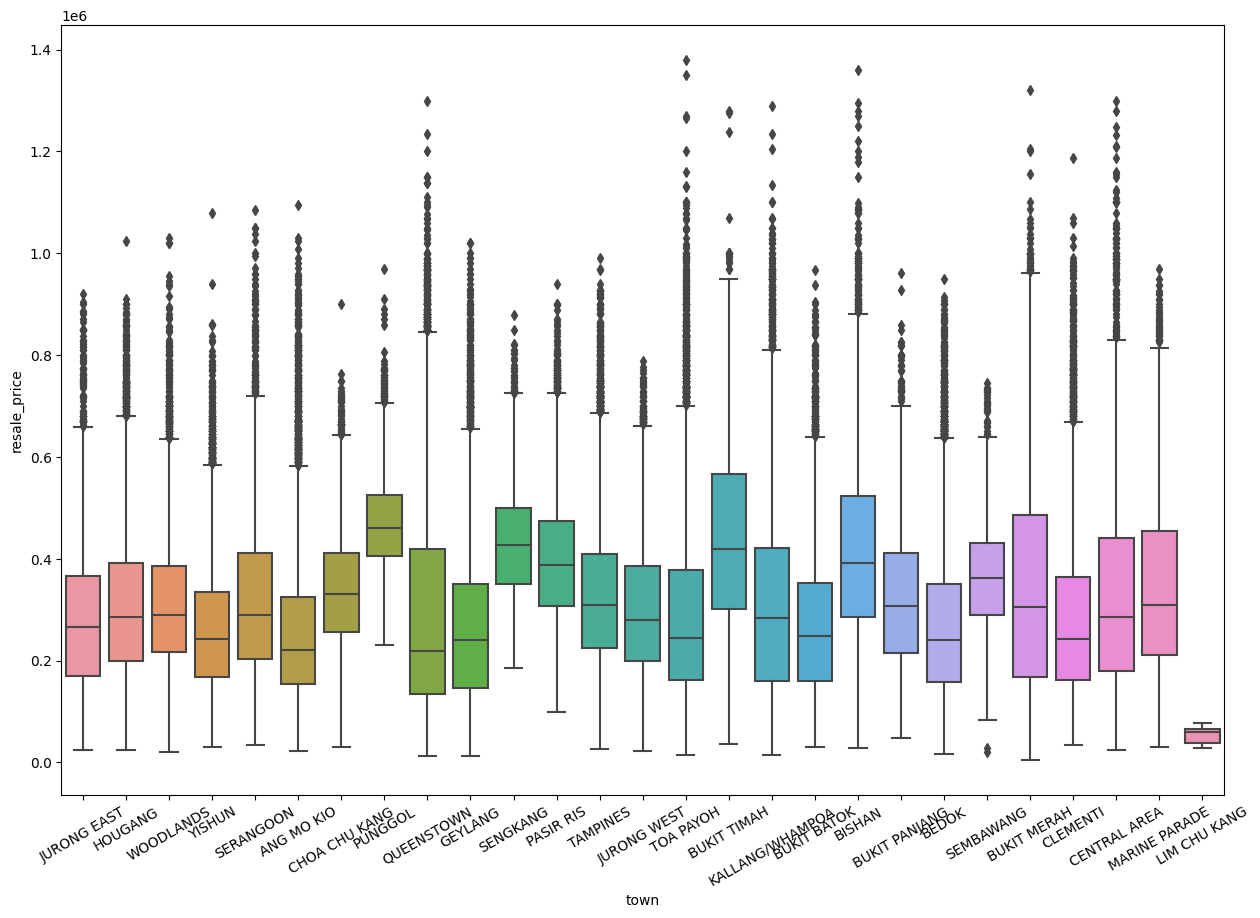

In [42]:
fig = plt.figure(figsize = (15,10))
ax = sns.boxplot(x='town', y='resale_price', data=train_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Price Trend

In [43]:
trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)

C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\1983881809.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)


In [44]:
trend_df

floor_area_sqm resale_price remaining_lease nearest_distance_to_mrt
               mean         mean            mean                    mean
year                                                                    
1990          85.34     70470.68           88.78                    1.05
1991          87.38     75772.70           88.88                    1.15
1992          89.05     87085.51           88.21                    1.09
1993          92.32    135189.68           87.91                    1.13
1994          93.20    175449.92           87.56                    1.14
1995          93.49    216260.80           86.96                    1.14
1996          92.32    284558.03           86.18                    1.18
1997          95.80    310453.96           86.19                    1.19
1998          96.57    259972.90           85.51                    1.20
1999          98.99    254318.82           85.19                    1.16
2000          96.45    259738.08           84.78                    0.69
2001          97.78    242763.63           85.14                    0.68
2002          98.38    236150.56           84.88                    0.69
2003          94.90    231137.08           83.21                    0.65
2004          93.95    235984.78           82.32                    0.64
2005          94.85    233739.95           81.93                    0.63
2006          96.13    236487.36           81.19                    0.63
2007          97.93    261490.07           81.01                    0.64
2008          97.89    319438.49           80.52                    0.63
2009          98.06    339043.84           79.65                    0.63
2010          97.57    379196.23           78.09                    0.63
2011          97.22    425968.58           77.55                    0.63
2012          97.18    461689.46           76.59                    0.63
2013          96.86    479456.53           75.60                    0.63
2014          94.96    443229.89           74.41                    0.63
2015          96.94    435055.85           73.73                    0.62
2016          97.40    440905.32           73.84                    0.60
2017          97.68    443138.86           74.14                    0.61
2018          99.35    446764.26           74.25                    0.61
2019          97.01    432490.61           74.07                    0.62
2020          97.38    452272.47           74.38                    0.62
2021          98.41    512270.20           74.91                    0.59
2022          97.20    552653.56           73.94                    0.61
2023          93.53    545622.77           74.08                    0.64

In [45]:
trend_df['floor_area_sqm'].idxmax().values[0]

2018

In [46]:
def print_max_min(col:str, max_min:str)->None:
    if max_min == 'max':
        res = f"Year with highest mean {col} : {trend_df[col].idxmax().values[0]} of {trend_df[col].max().values[0]}"
    elif max_min == 'min':
        res = f"Year with lowest mean {col} : {trend_df[col].idxmin().values[0]} of {trend_df[col].min().values[0]}"
    else:
        print('Please either indicate max or min')
    print(res)

In [47]:
print(f"Year with highest floor_area_sqm : {trend_df['floor_area_sqm'].idxmax().values[0]} of {trend_df['floor_area_sqm'].max().values[0]}")

Year with highest floor_area_sqm : 2018 of 99.35


In [48]:
for col , _ in trend_df.select_dtypes(exclude='object').columns:
    for metric in ['max', 'min']:
        print_max_min(col, metric)

Year with highest mean floor_area_sqm : 2018 of 99.35
Year with lowest mean floor_area_sqm : 1990 of 85.34
Year with highest mean resale_price : 2022 of 552653.56
Year with lowest mean resale_price : 1990 of 70470.68
Year with highest mean remaining_lease : 1991 of 88.88
Year with lowest mean remaining_lease : 2015 of 73.73
Year with highest mean nearest_distance_to_mrt : 1998 of 1.2
Year with lowest mean nearest_distance_to_mrt : 2021 of 0.59


C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\3635810421.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))


([<matplotlib.axis.XTick at 0x2ae0ea9e7c0>,
 [Text(1990, 0, '1990'),
  Text(1991, 0, '1991'),
  Text(1992, 0, '1992'),
  Text(1993, 0, '1993'),
  Text(1994, 0, '1994'),
  Text(1995, 0, '1995'),
  Text(1996, 0, '1996'),
  Text(1997, 0, '1997'),
  Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022')])

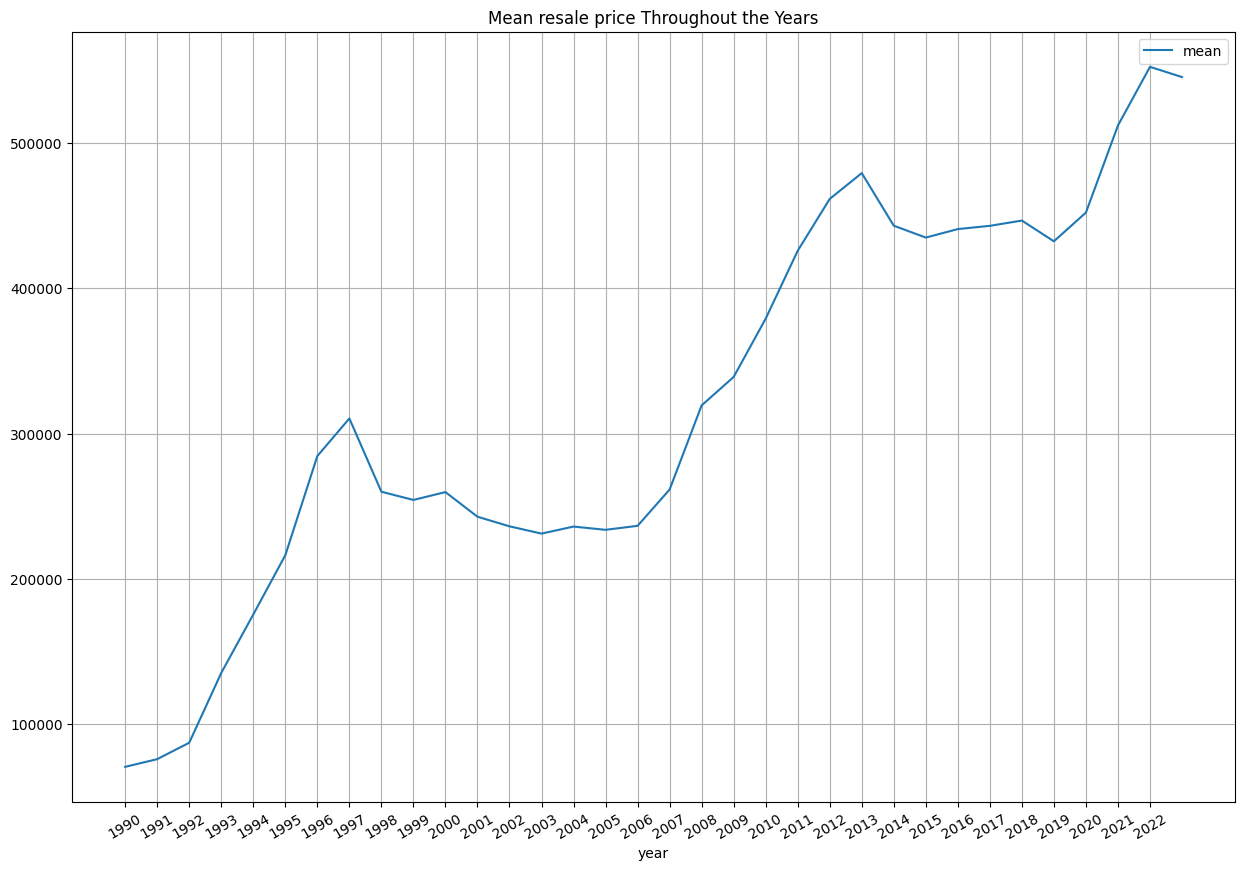

In [49]:
train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))
plt.xticks(range(1990,2023), rotation = 30)

C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\907755644.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))


([<matplotlib.axis.XTick at 0x2ae0ebd1730>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

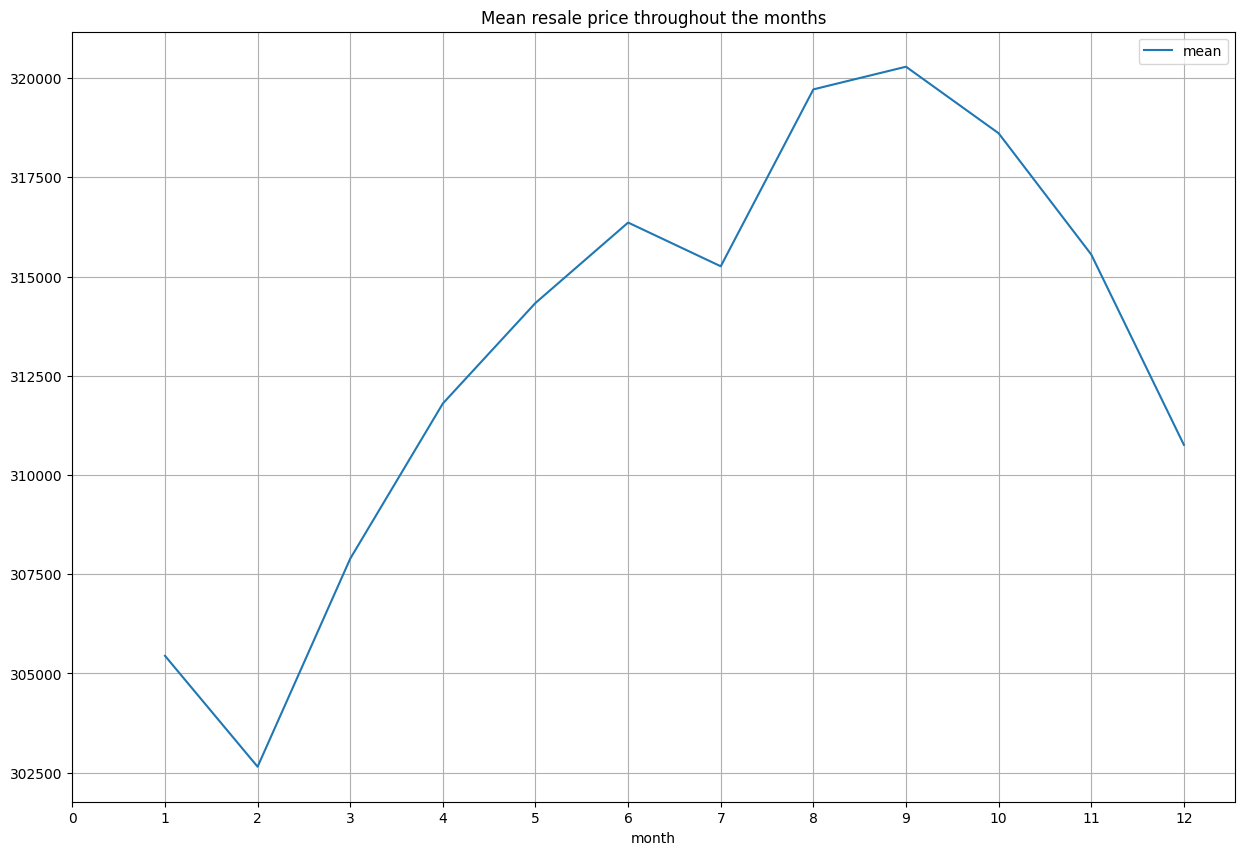

In [50]:
train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))
# figure = plt.gcf()
plt.xticks(range(0,13))

# Feature Selection I

In [51]:
# Pearson's correlation
# Do Clustering 

# Feature selection II:
# PCA, RFE, Lasso, Feature Importance using Random Forest

C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\176757758.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(train_df.corr())
C:\Users\Randy\AppData\Local\Temp\ipykernel_25920\176757758.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask=mask)


<AxesSubplot: >

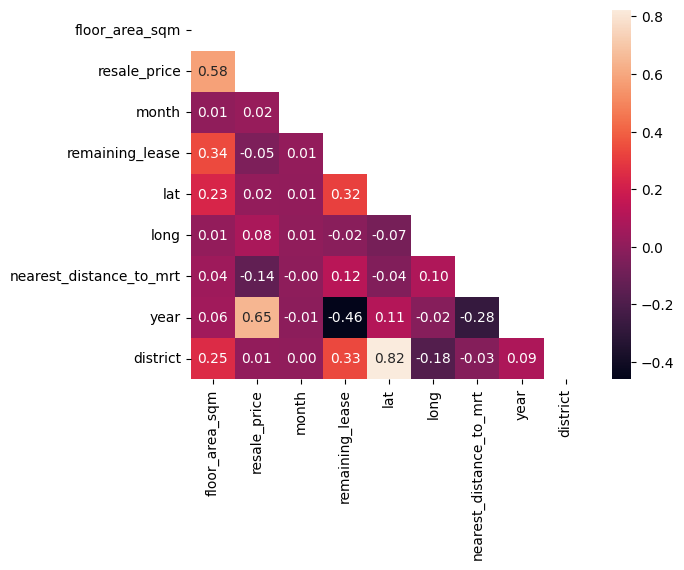

In [52]:
import seaborn as sns
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask=mask)

I was surprised that the distance to mrt is not a significant factor in affecting the price with the main one being the year it was sold as well as the floor area (which makes sense).

Perhaps it is because for resale markets, there is surviorship bias since only the ones gets sold are recorded here and they are already rather near to the MRT.

We see that district and floor area is correlated, it would be interesting to see which district has the largest floor area. There is also some correlation between the remaining lease and the floor area.

## Clustering

In [53]:
from sklearn.cluster import DBSCAN

In [54]:
dbscan = DBSCAN()
dbscan_ss = DBSCAN()

In [55]:
train_df.select_dtypes(exclude = 'object')

floor_area_sqm  resale_price  month  remaining_lease       lat  \
76365            103.0      395000.0      3               59  1.320308   
473179           121.0      265000.0      9               92  1.377158   
445613           101.0      208000.0      7               95  1.436909   
817033           146.0      430000.0      4               89  1.439970   
277677            74.0      223000.0      9               73  1.434565   
...                ...           ...    ...              ...       ...   
259178            76.0      320000.0      7               65  1.315432   
365838            67.0      158000.0     10               75  1.273954   
131932           105.0      242000.0      9               95  1.445433   
671155            65.0      203000.0      5               78  1.337572   
121958            68.0      298000.0      5               51  1.336285   

              long  nearest_distance_to_mrt  year  district  
76365   103.738968                    1.475  2021      60.0  
473179  103.877524                    1.641  2006      53.0  
445613  103.801599                    0.415  2002      73.0  
817033  103.787772                    0.398  1998      73.0  
277677  103.827974                    0.966  2009      76.0  
...            ...                      ...   ...       ...  
259178  103.871652                    0.439  2009      38.0  
365838  103.808817                    0.376  2002      10.0  
131932  103.791997                    0.770  2000      73.0  
671155  103.858844                    1.375  1997      31.0  
121958  103.849406                    0.458  2019      31.0  

[176039 rows x 9 columns]

In [56]:
train_df_x = train_df.select_dtypes(exclude = 'object').loc[:, train_df.select_dtypes(exclude = 'object').columns != 'resale_price']

In [57]:
train_df_x.columns

Index(['floor_area_sqm', 'month', 'remaining_lease', 'lat', 'long',
       'nearest_distance_to_mrt', 'year', 'district'],
      dtype='object')

In [58]:
dbscan.fit(train_df_x)

DBSCAN()

In [59]:
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 815
Estimated number of noise points: 171319


In [60]:
from sklearn.preprocessing import StandardScaler

In [61]:
train_df_x_ss = StandardScaler().fit_transform(train_df_x)

In [62]:
dbscan_ss.fit(train_df_x_ss)

DBSCAN()

In [63]:
labels = dbscan_ss.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 579
Estimated number of noise points: 8975


In [64]:
# Running PCA to reduce the number of dimensions before running clustering

In [65]:
from sklearn.decomposition import PCA

In [66]:
pca = PCA(n_components=0.95)
pca_ss = PCA(n_components=0.95)

In [67]:
train_df_x_pca = pca.fit_transform(train_df_x)
train_df_x_ss_pca = pca_ss.fit_transform(train_df_x_ss)

## PCA Components

In [68]:
train_df_x_ss_pd = pd.DataFrame(train_df_x_ss, columns=train_df_x.columns)

In [69]:
pca_ss.fit(train_df_x_ss_pd)

PCA(n_components=0.95)

In [70]:
pd.DataFrame(list(zip(["pca " + str(idx) for idx in range(1,len(pca_ss.explained_variance_ratio_))] ,pca_ss.explained_variance_ratio_)), columns=['PCA', 'Explained Variance'])

PCA  Explained Variance
0  pca 1            0.277612
1  pca 2            0.196045
2  pca 3            0.127657
3  pca 4            0.124882
4  pca 5            0.109497
5  pca 6            0.101062

In [71]:
np.sum(pca_ss.components_[0])

-1.8024962441787873

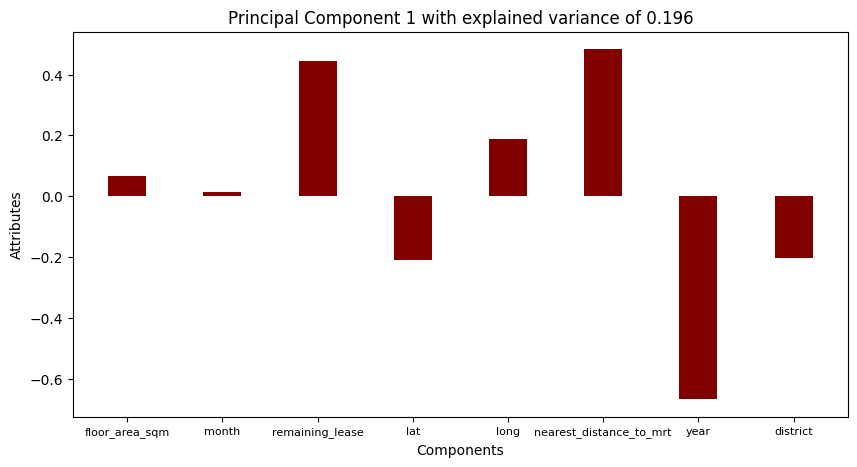

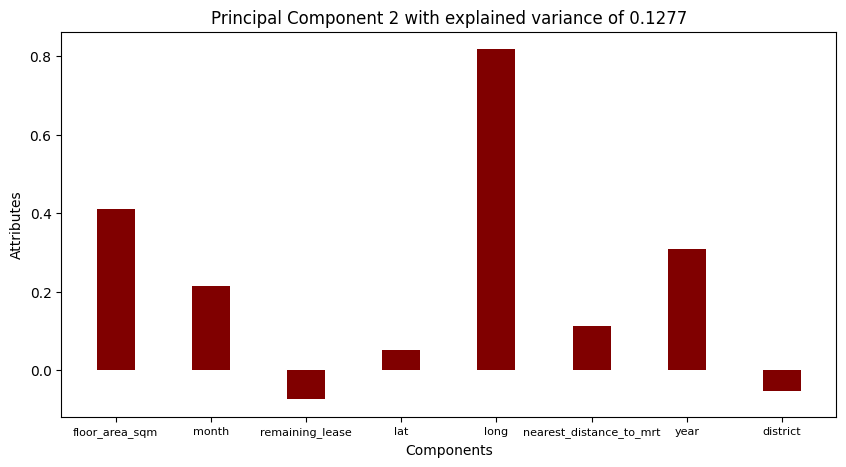

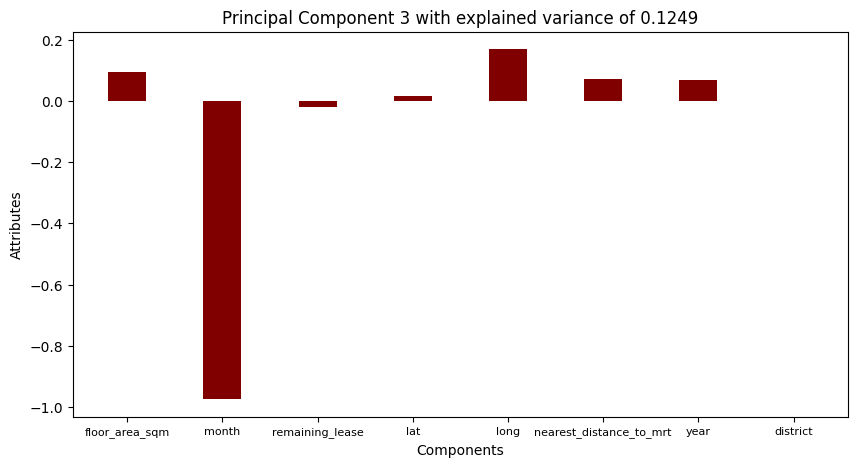

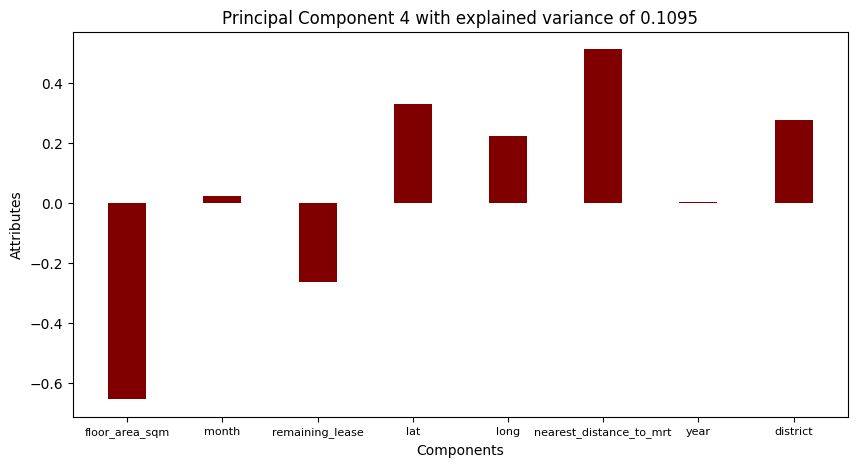

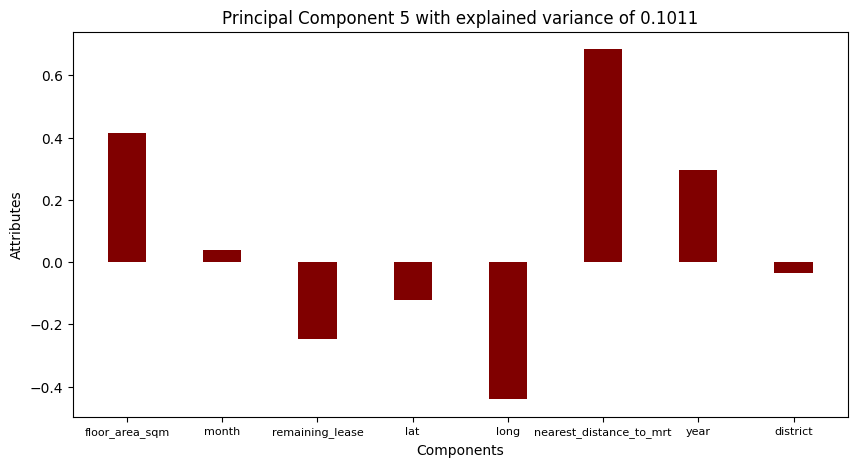

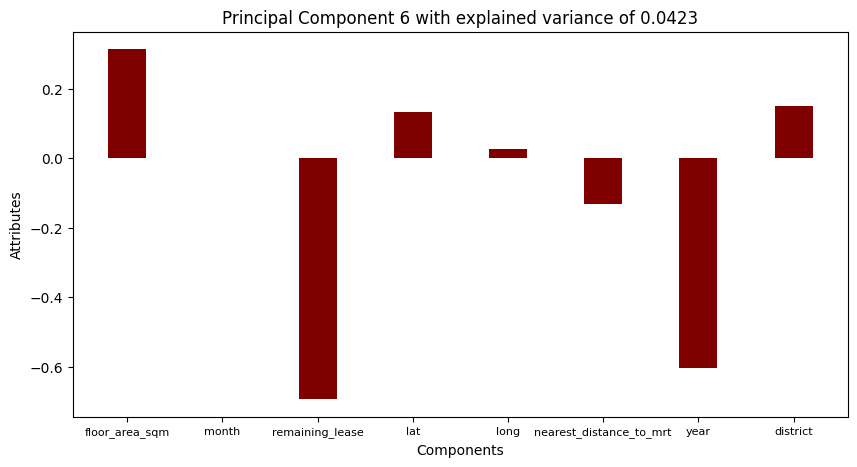

In [72]:
for idx in range(1,len(pca_ss.explained_variance_ratio_)):
    fig = plt.figure(figsize = (10, 5))
    plt.bar(pca_ss.feature_names_in_, pca_ss.components_[idx], width = 0.4, color = 'maroon')
    plt.xlabel("Components")
    plt.xticks(size = 8)
    plt.ylabel("Attributes")
    plt.title(f"Principal Component {idx} with explained variance of {round(pca_ss.explained_variance_ratio_[idx],4)}")
    plt.show()

PCA tells us where the variation of the data comes from.

The combined 6 principle components (PC) inform us 95% of the variance in the dataset, out of which the 1st 2 PC only informs us approximately 35% of the variance in the dataset

In [73]:
dbscan_pca = DBSCAN()
dbscan_ss_pca = DBSCAN()

In [74]:
dbscan_pca.fit(train_df_x_pca)
dbscan_ss_pca.fit(train_df_x_ss_pca)

DBSCAN()

In [75]:
labels = dbscan_pca.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 9048
Estimated number of noise points: 76239


In [76]:
labels = dbscan_ss_pca.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 467
Estimated number of noise points: 7370


In [77]:
for eps in [0.5,1,1.5,2.0]:
    dbscan = DBSCAN(eps = eps)
    dbscan.fit(train_df_x_ss_pca)

    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print(f"Fitted: eps: {eps} in DBSCAN")
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

Fitted: eps: 0.5 in DBSCAN
Estimated number of clusters: 467
Estimated number of noise points: 7370
Fitted: eps: 1 in DBSCAN
Estimated number of clusters: 15
Estimated number of noise points: 104
Fitted: eps: 1.5 in DBSCAN
Estimated number of clusters: 3
Estimated number of noise points: 20
Fitted: eps: 2.0 in DBSCAN
Estimated number of clusters: 2
Estimated number of noise points: 8


Seems like eps 1 or 1.5 is good with 15 and 3 clusters respectively

In [78]:
dbscan = DBSCAN(eps = 1.5)
dbscan.fit(train_df_x_ss_pca)
train_df['dbscan_label']= dbscan.labels_

In [79]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [166]:
train_df

town  flat_type      flat_model  floor_area_sqm  \
76365       JURONG EAST     4 ROOM  New Generation           103.0   
473179          HOUGANG     5 ROOM        Improved           121.0   
445613        WOODLANDS     4 ROOM         Model A           101.0   
817033        WOODLANDS  EXECUTIVE      MAISONETTE           146.0   
277677           YISHUN     3 ROOM         Model A            74.0   
...                 ...        ...             ...             ...   
259178  KALLANG/WHAMPOA     3 ROOM        Improved            76.0   
365838      BUKIT MERAH     3 ROOM  New Generation            67.0   
131932        WOODLANDS     4 ROOM         Model A           105.0   
671155        TOA PAYOH     3 ROOM        IMPROVED            65.0   
121958        TOA PAYOH     3 ROOM        Improved            68.0   

        resale_price  month storey_range  remaining_lease  \
76365       395000.0      3     10 TO 12               59   
473179      265000.0      9     01 TO 03               92   
445613      208000.0      7     07 TO 09               95   
817033      430000.0      4     04 TO 06               89   
277677      223000.0      9     07 TO 09               73   
...              ...    ...          ...              ...   
259178      320000.0      7     13 TO 15               65   
365838      158000.0     10     13 TO 15               75   
131932      242000.0      9     07 TO 09               95   
671155      203000.0      5     07 TO 09               78   
121958      298000.0      5     07 TO 09               51   

                                             full_address       lat  \
76365              31 TEBAN GARDENS ROAD SINGAPORE 600031  1.320308   
473179              964 HOUGANG AVENUE 9 SINGAPORE 530964  1.377158   
445613           644 WOODLANDS RING ROAD SINGAPORE 730644  1.436909   
817033           804 WOODLANDS STREET 81 SINGAPORE 730804  1.439970   
277677  115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...  1.434565   
...                                                   ...       ...   
259178  16 UPPER BOON KENG ROAD BOON KENG VILLE SINGAP...  1.315432   
365838  77 TELOK BLANGAH DRIVE DBS TELOK BLANGAH DRIVE...  1.273954   
131932            878 WOODLANDS AVENUE 9 SINGAPORE 730878  1.445433   
671155  232 LORONG 8 TOA PAYOH PCF SPARKLETOTS PRESCHO...  1.337572   
121958            85A LORONG 4 TOA PAYOH SINGAPORE 311085  1.336285   

              long       nearest_mrt  nearest_distance_to_mrt  year  district  \
76365   103.738968       jurong east                    1.475  2021      60.0   
473179  103.877524          tongkang                    1.641  2006      53.0   
445613  103.801599         admiralty                    0.415  2002      73.0   
817033  103.787772         woodlands                    0.398  1998      73.0   
277677  103.827974          canberra                    0.966  2009      76.0   
...            ...               ...                      ...   ...       ...   
259178  103.871652           kallang                    0.439  2009      38.0   
365838  103.808817     telok blangah                    0.376  2002      10.0   
131932  103.791997  woodlands north                     0.770  2000      73.0   
671155  103.858844         toa payoh                    1.375  1997      31.0   
121958  103.849406         toa payoh                    0.458  2019      31.0   

        dbscan_label  
76365              0  
473179             0  
445613             0  
817033             0  
277677             0  
...              ...  
259178             0  
365838             0  
131932             0  
671155             0  
121958             0  

[176039 rows x 16 columns]

In [167]:
train, test = train_test_split(train_df, test_size = TEST_SIZE)

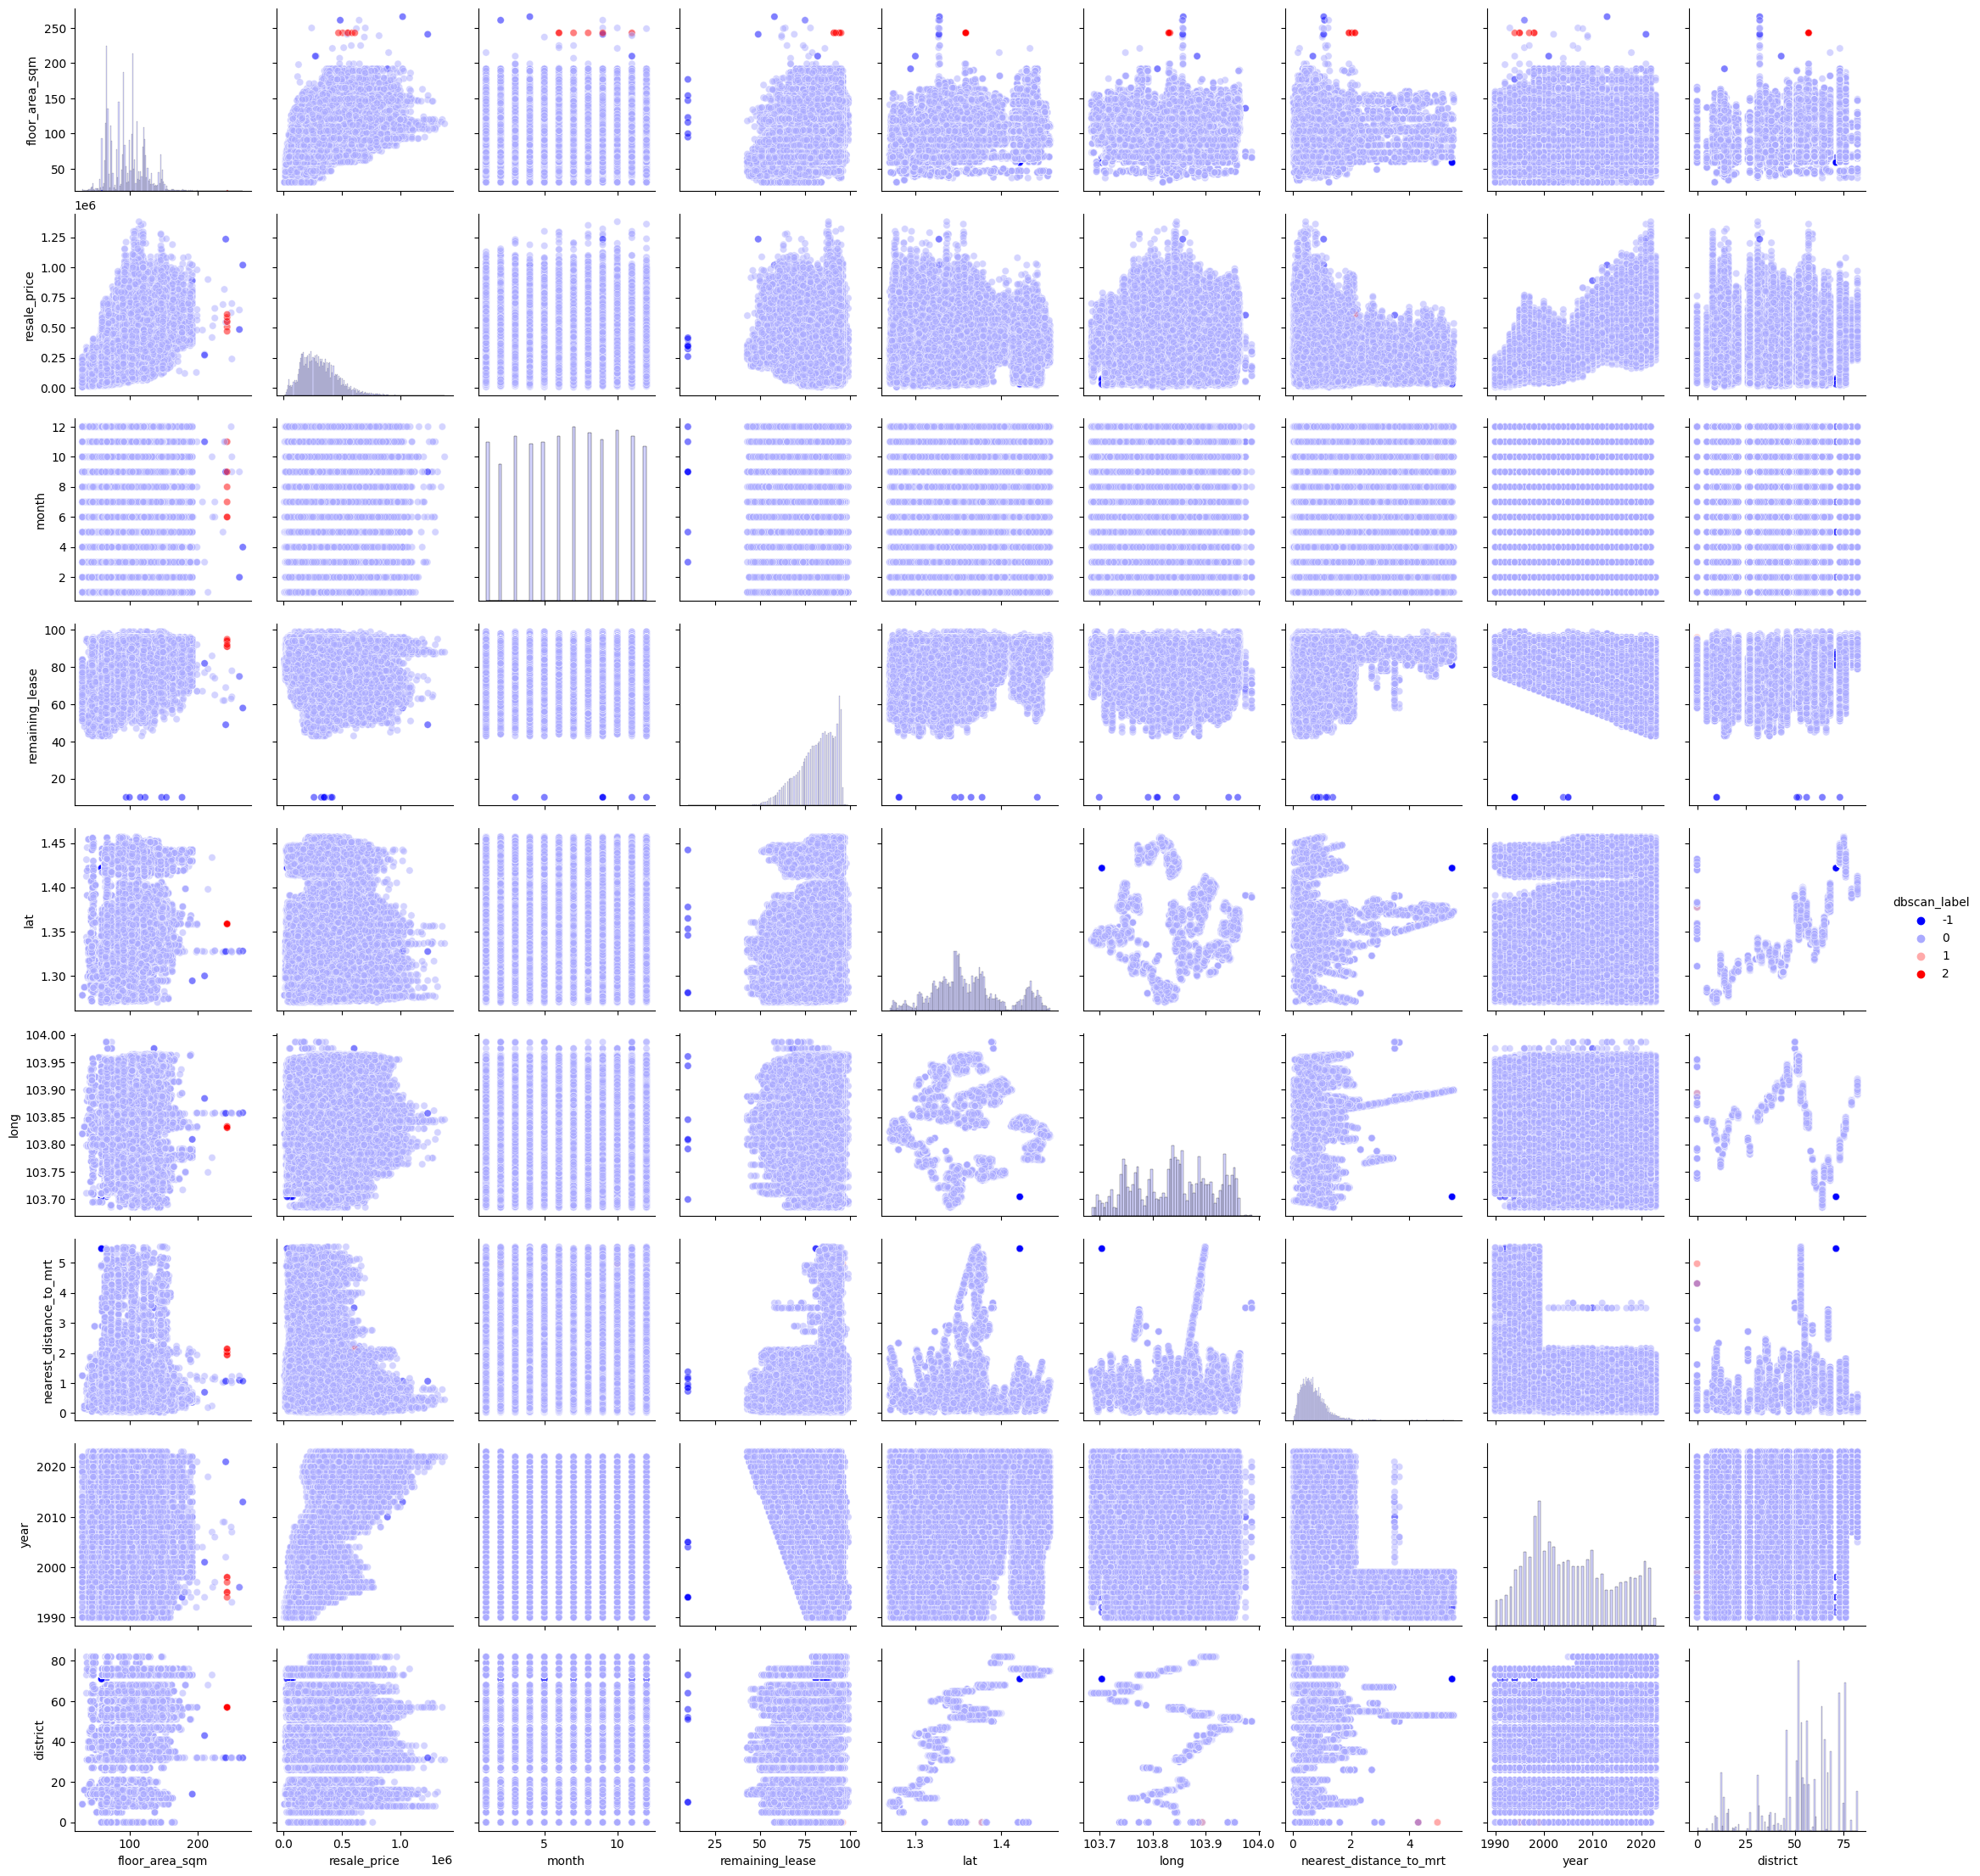

In [107]:
# whole dataset took 14 mins
train_df_smaller = train_df.sample(int(len(train_df)/100), random_state =SEED)
# sns.pairplot(train_df_smaller, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist" , plot_kws ={'alpha':0.5})#, markers=["o", "s"])
sns.pairplot(train_df, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist", plot_kws ={'alpha':0.5} )#, markers=["o", "s"])

In [81]:
print(len(train_df[train_df['dbscan_label']== -1]))

20


In [82]:
train_df[train_df['dbscan_label']== -1]

town  flat_type     flat_model  floor_area_sqm  \
813045  KALLANG/WHAMPOA     3 ROOM        TERRACE           261.0   
308208       QUEENSTOWN  EXECUTIVE     Maisonette           192.0   
853162        WOODLANDS  EXECUTIVE      APARTMENT           177.0   
386729  KALLANG/WHAMPOA     3 ROOM        Terrace           266.0   
777244     LIM CHU KANG     3 ROOM       IMPROVED            66.0   
777247     LIM CHU KANG     3 ROOM       IMPROVED            59.0   
849549         TAMPINES  EXECUTIVE      APARTMENT           147.0   
777264     LIM CHU KANG     3 ROOM       IMPROVED            59.0   
517909       ANG MO KIO     4 ROOM        Model A            95.0   
716675          HOUGANG     3 ROOM        MODEL A            74.0   
258136  KALLANG/WHAMPOA     5 ROOM  Adjoined flat           136.0   
777235     LIM CHU KANG     3 ROOM       IMPROVED            59.0   
498135      BUKIT MERAH     4 ROOM        Model A           100.0   
777260     LIM CHU KANG     3 ROOM       IMPROVED            59.0   
386666  KALLANG/WHAMPOA     5 ROOM  Adjoined flat           210.0   
777239     LIM CHU KANG     3 ROOM       IMPROVED            59.0   
458251  KALLANG/WHAMPOA     3 ROOM        Terrace           241.0   
854796      JURONG WEST     5 ROOM       IMPROVED           123.0   
854246        PASIR RIS  EXECUTIVE      APARTMENT           154.0   
508365      BUKIT MERAH     5 ROOM       Improved           116.0   

        resale_price  month storey_range  remaining_lease  \
813045      485000.0      2     01 TO 03               75   
308208      890000.0      7     22 TO 24               82   
853162      405000.0      9     04 TO 06               10   
386729     1020000.0      4     01 TO 03               58   
777244       55000.0      7     01 TO 03               85   
777247       63500.0     11     01 TO 03               85   
849549      356000.0      5     04 TO 06               10   
777264       67000.0     12     01 TO 03               81   
517909      323000.0      9     16 TO 18               10   
716675      148000.0     12     04 TO 06               85   
258136      604000.0     11     07 TO 09               68   
777235       28700.0      5     04 TO 06               88   
498135      348000.0      9     22 TO 24               10   
777260       77000.0      5     01 TO 03               81   
386666      271888.0     11     07 TO 09               82   
777239       31900.0      2     04 TO 06               87   
458251     1235000.0      9     01 TO 03               49   
854796      260000.0     12     01 TO 03               10   
854246      345000.0     11     07 TO 09               10   
508365      416300.0      3     07 TO 09               10   

                                             full_address       lat  \
813045                   54 JALAN MA'MOR SINGAPORE 320054  1.328255   
308208              81 STRATHMORE AVENUE SINGAPORE 141081  1.294620   
853162           847 WOODLANDS STREET 82 SINGAPORE 730847  1.442153   
386729                   65 JALAN MA'MOR SINGAPORE 320065  1.328204   
777244               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
777247               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
849549            332 TAMPINES STREET 32 SINGAPORE 520332  1.353168   
777264               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
517909  309A ANG MO KIO STREET 31 TECK GHEE VISTA SING...  1.365029   
716675                              210 HOUGANG STREET 21  1.359464   
258136  2 ANDOVER ROAD CHANGI BEACH CLUB SINGAPORE 509984  1.390951   
777235               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
498135     112A DEPOT ROAD DEPOT HEIGHTS SINGAPORE 101112  1.281476   
777260               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
386666  14 KAMPONG ARANG ROAD MOUNTBATTEN CONSTITUENCY...  1.300178   
777239               4 LIM CHU KANG ROAD SINGAPORE 710004  1.421752   
458251  46 JALAN BAHAGIA WHAMPOA GARDENS SINGAPORE 320046  1.327647   
854796  7

(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000.]),
 [Text(0.0, 0, '0'),
  Text(200000.0, 0, '200000'),
  Text(400000.0, 0, '400000'),
  Text(600000.0, 0, '600000'),
  Text(800000.0, 0, '800000'),
  Text(1000000.0, 0, '1000000'),
  Text(1200000.0, 0, '1200000'),
  Text(1400000.0, 0, '1400000'),
  Text(1600000.0, 0, '1600000')])

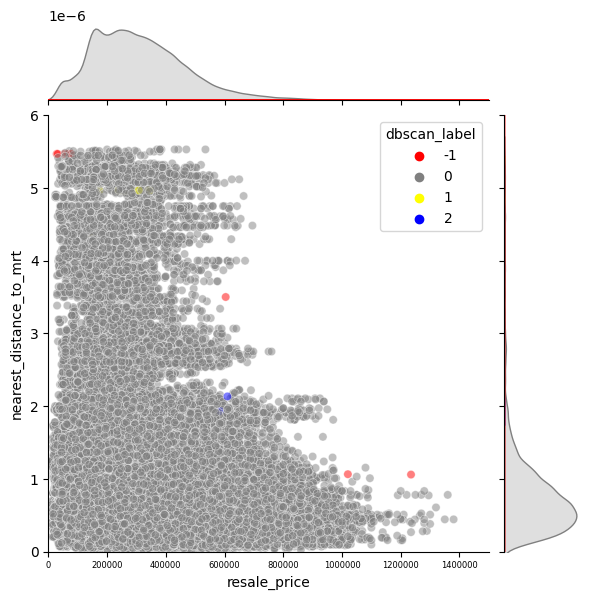

In [105]:
sns.jointplot(
    train_df,
    x='resale_price', 
    y='nearest_distance_to_mrt', 
    hue='dbscan_label',
    joint_kws={'alpha':0.5}, 
    palette=['red','gray','yellow','blue'], 
    marginal_ticks = False,
    xlim = (0,1500000),
    ylim = (0,6) );
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(size = 6)

Lets try 15 clusters with eps = 1

In [108]:
dbscan = DBSCAN(eps = 1.0)
dbscan.fit(train_df_x_ss_pca)
train_df['dbscan_label']= dbscan.labels_

In [109]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

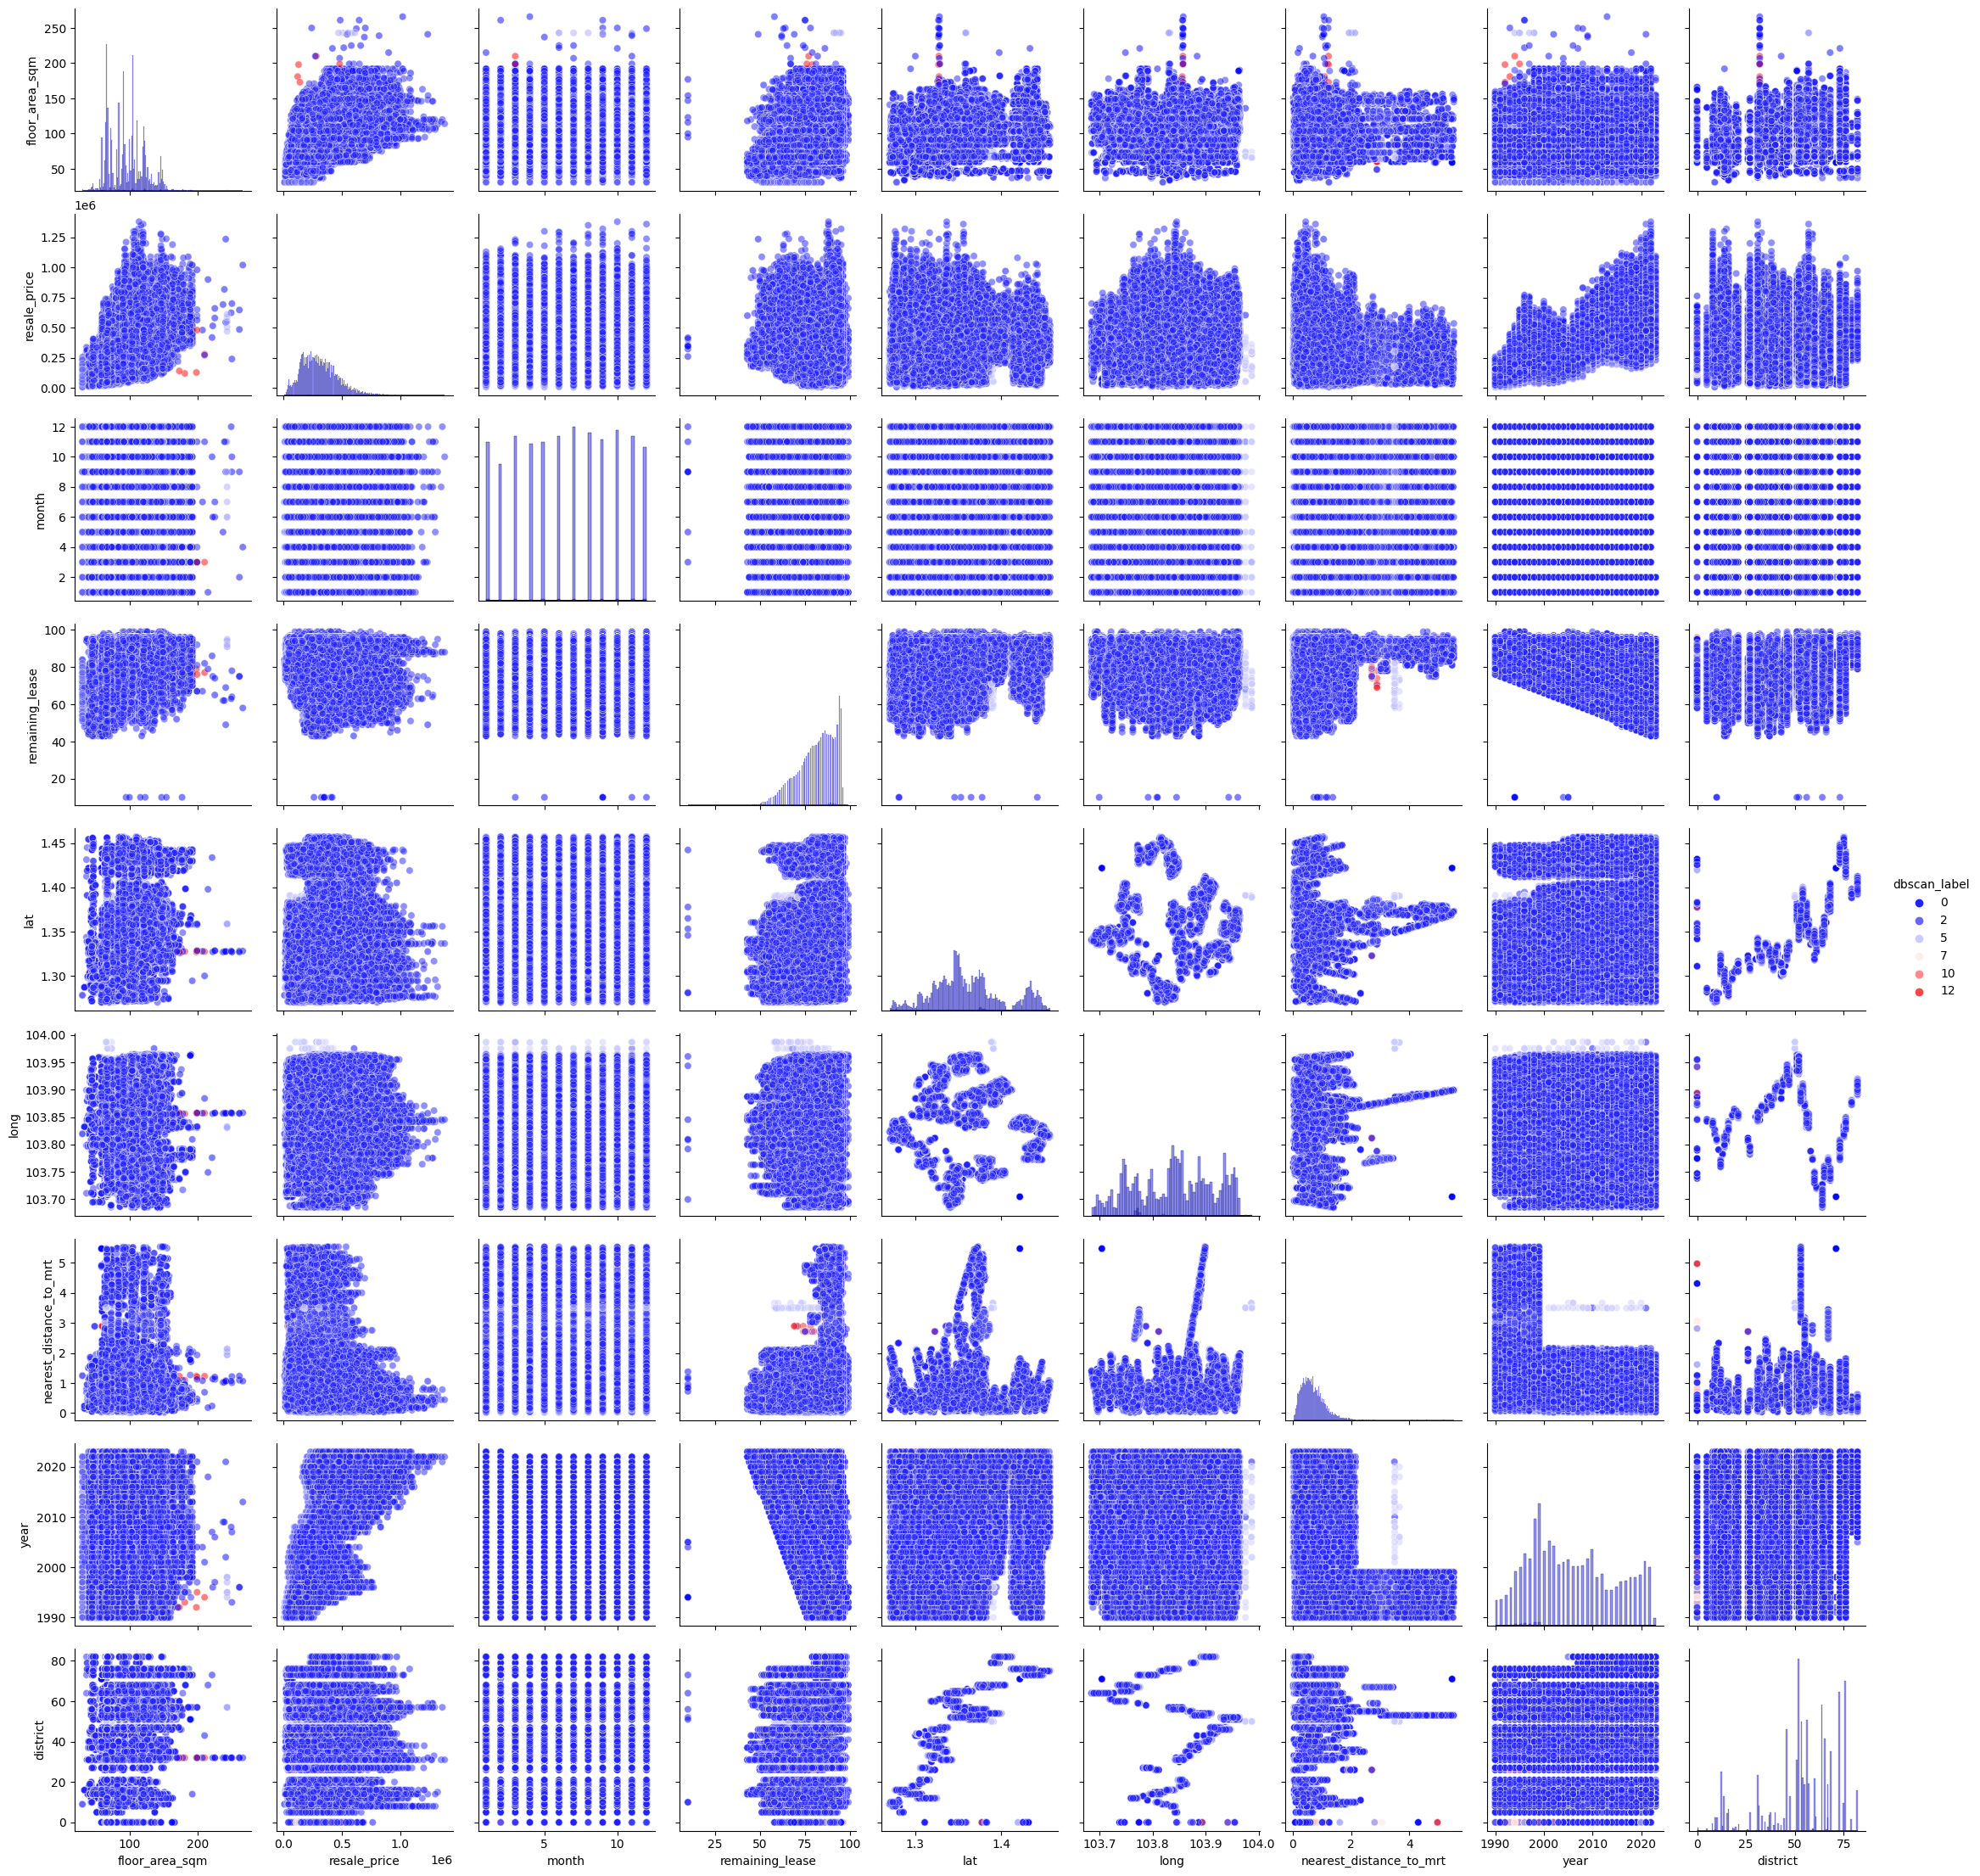

In [110]:
# whole dataset took 14 mins
train_df_smaller = train_df.sample(int(len(train_df)/100), random_state =SEED)
# sns.pairplot(train_df_smaller, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist" , plot_kws ={'alpha':0.5})#, markers=["o", "s"])
sns.pairplot(train_df, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist", plot_kws ={'alpha':0.5} )#, markers=["o", "s"])

(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000.]),
 [Text(0.0, 0, '0'),
  Text(200000.0, 0, '200000'),
  Text(400000.0, 0, '400000'),
  Text(600000.0, 0, '600000'),
  Text(800000.0, 0, '800000'),
  Text(1000000.0, 0, '1000000'),
  Text(1200000.0, 0, '1200000'),
  Text(1400000.0, 0, '1400000'),
  Text(1600000.0, 0, '1600000')])

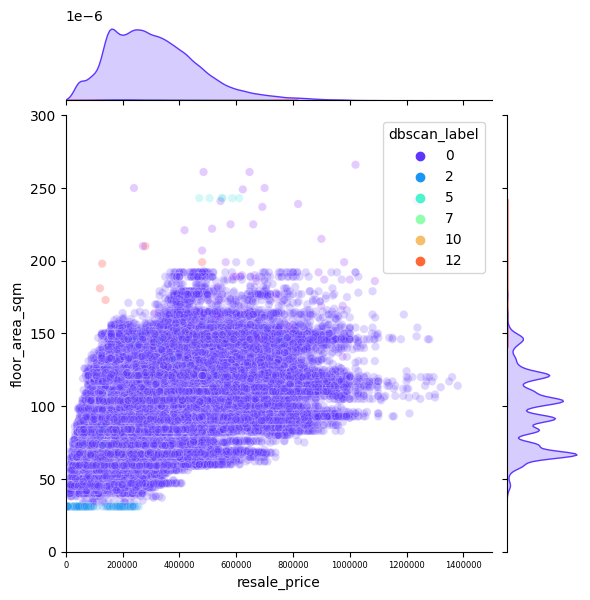

In [123]:
sns.jointplot(
    train_df,
    x='resale_price', 
    y='floor_area_sqm', 
    hue='dbscan_label',
    joint_kws={'alpha':0.2}, 
    palette = 'rainbow',
    # palette=['red','gray','yellow','blue'], 
    marginal_ticks = False,
    xlim = (0,1500000),
    ylim = (0,300));
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(size = 6)

In [125]:
train_df.head()

town  flat_type      flat_model  floor_area_sqm  resale_price  \
76365   JURONG EAST     4 ROOM  New Generation           103.0      395000.0   
473179      HOUGANG     5 ROOM        Improved           121.0      265000.0   
445613    WOODLANDS     4 ROOM         Model A           101.0      208000.0   
817033    WOODLANDS  EXECUTIVE      MAISONETTE           146.0      430000.0   
277677       YISHUN     3 ROOM         Model A            74.0      223000.0   

        month storey_range  remaining_lease  \
76365       3     10 TO 12               59   
473179      9     01 TO 03               92   
445613      7     07 TO 09               95   
817033      4     04 TO 06               89   
277677      9     07 TO 09               73   

                                             full_address       lat  \
76365              31 TEBAN GARDENS ROAD SINGAPORE 600031  1.320308   
473179              964 HOUGANG AVENUE 9 SINGAPORE 530964  1.377158   
445613           644 WOODLANDS RING ROAD SINGAPORE 730644  1.436909   
817033           804 WOODLANDS STREET 81 SINGAPORE 730804  1.439970   
277677  115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...  1.434565   

              long  nearest_mrt  nearest_distance_to_mrt  year  district  \
76365   103.738968  jurong east                    1.475  2021      60.0   
473179  103.877524     tongkang                    1.641  2006      53.0   
445613  103.801599    admiralty                    0.415  2002      73.0   
817033  103.787772    woodlands                    0.398  1998      73.0   
277677  103.827974     canberra                    0.966  2009      76.0   

        dbscan_label  
76365              0  
473179             0  
445613             0  
817033             0  
277677             0

In [126]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder , PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle

In [130]:
y_train = train_df.resale_price
X_train = train_df.loc[:, train_df.columns != 'resale_price']

In [132]:
num_cols = X_train.select_dtypes(['float64','int64']).columns
cat_cols = X_train.select_dtypes(['object']).columns

In [133]:
train_df.shape

(176039, 16)

In [134]:
num_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures())
])

# One hot encoding categorical variables

cat_pipline = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

preprocess = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipline, cat_cols)
])

In [135]:
X_train_preprocessed = preprocess.fit_transform(X_train)
print(X_train_preprocessed.shape)

(176039, 9733)


In [136]:
def plot_results(score, title):
    
    train_score = score['train_score']
    test_score = score['test_score']
    
    train_score = (-train_score)**(1/2) 
    test_score = (-test_score)**(1/2)
    
    cv = len(score['score_time'])
    
    fig, ax = plt.subplots(figsize = (5,5))
    
    ax.plot(range(cv), train_score, 'r-', label = 'Training RMSE')
    ax.plot(range(cv), test_score, 'b--', label = 'Validation RMSE')
    ax.set_title(title)
    ax.set_xlabel('K-Folds')
    ax.set_ylabel('Error')
    ax.legend()
    plt.show()

In [138]:
model_list = {'Linear Regression':LinearRegression(), 
              'Lasso':Lasso(),
              'Ridge': Ridge(), 
              'Light Gradient Boosting Machine' : lgb.LGBMRegressor(random_state=SEED),
              'Extreme Gradient Boosting Machine' : xgb.XGBRegressor(random_state=SEED),
              'Decision Tree' :DecisionTreeRegressor(),
              'Random Forest' :RandomForestRegressor()
             }

In [139]:
from sklearn.model_selection import cross_validate

Model is  Linear Regression
Mean Train RMSE 24708.684213737983
Train RMSE  [-620397101.5764189, -626874693.4628944, -592856871.5193853, -602464649.0801693, -614411260.8426267, -629652928.0258231, -613230866.3674959, -611862390.2830045, -601767048.2584006, -592304101.7078052]
Val RMSE  [-5984472062.512716, -5342027522.428834, -7408048291.954222, -6563912267.366463, -5419866831.417089, -6487836361.62927, -5370995417.818119, -25232045916.657734, -6147598222.476999, -5331759635.379293]
Mean Val RMSE  85526.1968044465


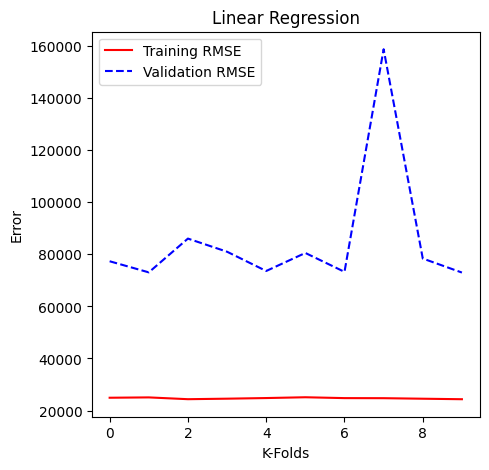

c:\tools\miniconda3\envs\hdb-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2400777071023.843, tolerance: 13205291285.10265
  model = cd_fast.sparse_enet_coordinate_descent(


Model is  Lasso
Mean Train RMSE 25328.89009057967
Train RMSE  [-652389187.306079, -660166764.3481178, -626376721.4976662, -629994805.3986235, -645383117.613296, -658445069.9574065, -643822146.6361513, -644315533.5609392, -630382295.8786938, -624852512.4954973]
Val RMSE  [-4667300010.34165, -4251792304.1912374, -5695975434.27974, -5523674274.975664, -4229565480.254232, -5472244429.084297, -4657973449.852226, -4504206243.266113, -5372362969.9131775, -4463944613.665176]
Mean Val RMSE  69779.81448429462


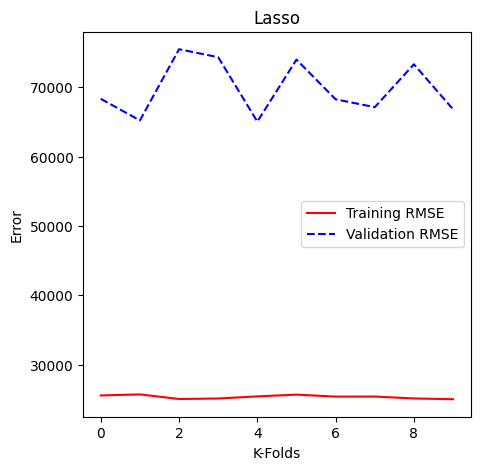

Model is  Ridge
Mean Train RMSE 35225.348077874616
Train RMSE  [-1251008254.3235395, -1270096211.4809272, -1217436197.9181814, -1231280517.2419107, -1256211206.7306962, -1244532799.7574723, -1234558862.883387, -1251110630.6840398, -1219266756.4374557, -1233256521.6432648]
Val RMSE  [-3623275255.114173, -3276502837.129583, -4409503005.584263, -3961414404.7936287, -3317279172.519113, -4149044337.232786, -3938391724.01609, -3927091791.9376144, -4224079865.6570024, -3644114898.3469553]
Mean Val RMSE  61956.96971525687


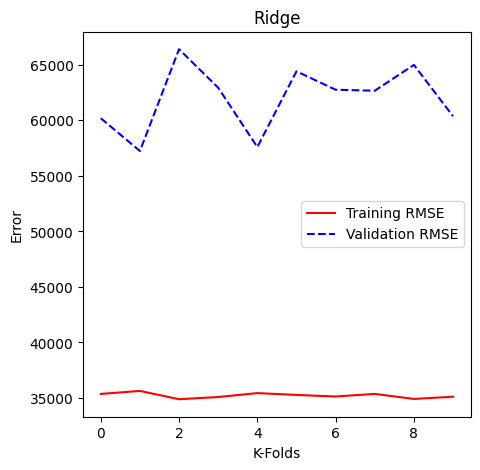

Model is  Light Gradient Boosting Machine
Mean Train RMSE 21587.454128288104
Train RMSE  [-452825955.4741962, -471091147.1833761, -480939717.80470824, -458531035.3072298, -462394579.29923385, -471144611.55069315, -461407824.21373683, -468660319.4165731, -473867758.49112165, -459665994.16839224]
Val RMSE  [-1332682593.4543228, -1651814029.0123324, -1424591390.368244, -1539440037.3245842, -1178450483.4804778, -1993403042.4074283, -1929882671.7640562, -1298021139.0710378, -1767863188.3284535, -1274120741.9466136]
Mean Val RMSE  39080.32910845379


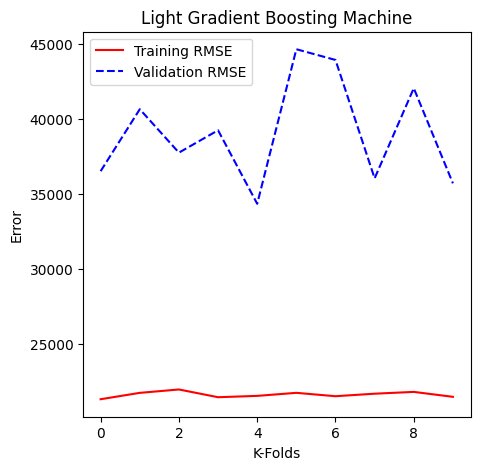

Model is  Extreme Gradient Boosting Machine
Mean Train RMSE 17046.998700896947
Train RMSE  [-307535539.45573556, -301813387.22884935, -292437572.26588356, -302231430.08091, -302067736.4996987, -268547142.9196924, -265678246.03859445, -318813409.4257167, -269846386.28264076, -279739533.26289785]
Val RMSE  [-1629850074.560578, -1548561466.2440126, -1460848531.934907, -1491365218.440772, -1262687387.9478953, -2007667082.9788477, -1841271304.872045, -1385178009.4537237, -2036919093.5496318, -1408143645.8888364]
Mean Val RMSE  39968.92218849409


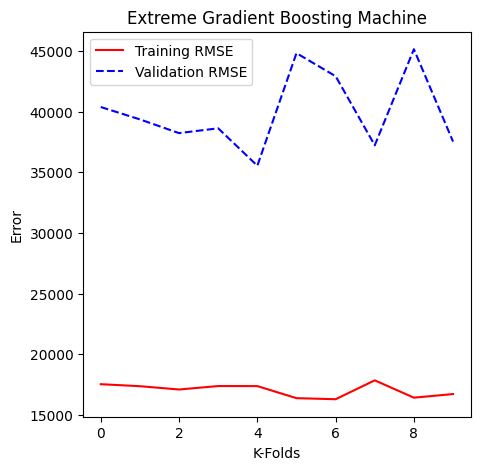

Model is  Decision Tree
Mean Train RMSE 0.0
Train RMSE  [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
Val RMSE  [-4330817707.69, -4484130442.232, -4520347179.01796, -4290976887.154, -4102623532.20396, -4726164365.722, -4524999966.58, -5646034777.804, -4229986143.132, -3636662623.082]
Mean Val RMSE  66606.18168233805


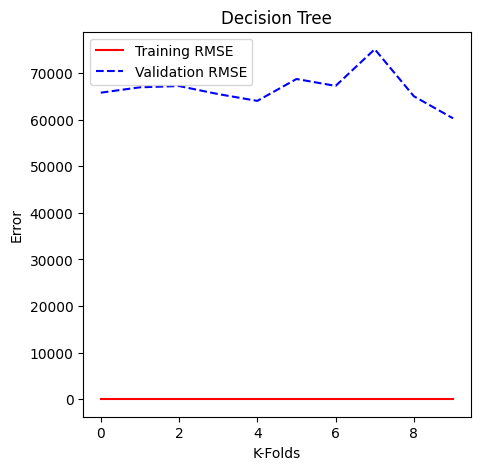

Model is  Random Forest
Mean Train RMSE 17640.31858446959
Train RMSE  [-302869438.4197772, -324111465.1069194, -312482102.4701442, -310438686.92417467, -320652215.90271324, -310482008.35453886, -302187777.5759481, -309077670.1360033, -303362909.525998, -316547334.9887596]
Val RMSE  [-2058825126.2687564, -2202269100.2497144, -2033617605.6266117, -2187325688.423137, -1805514596.077232, -2826623008.0349264, -2743325680.8781176, -1828348091.7185483, -2417619632.0547123, -2010520932.4932034]
Mean Val RMSE  46896.85461219315


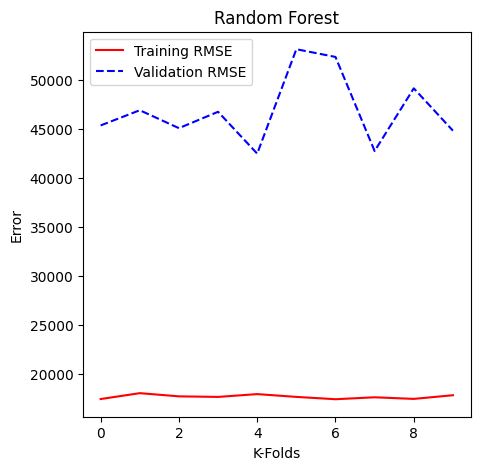

In [140]:
cv = 10
training_samples = 5000

train_rmse_list = []
val_rmse_list = []

for name , model in model_list.items():
    model_instance = model.fit(X_train_preprocessed[:training_samples], y_train[:training_samples])
    
    model_cv_score = cross_validate(model_instance,X_train_preprocessed[:training_samples], y_train[:training_samples], scoring = 'neg_mean_squared_error', cv=cv, n_jobs = -1,return_train_score= True )
    
    train_rmse_list.append(model_cv_score['train_score'])
    val_rmse_list.append(model_cv_score['test_score'])
    
    print('Model is ', name)
    print('Mean Train RMSE', ((-model_cv_score['train_score'])**(1/2)).mean())
    print('Train RMSE ', list(model_cv_score['train_score']))
    print('Val RMSE ' , list(model_cv_score['test_score']))
    print('Mean Val RMSE ' , ((-model_cv_score['test_score'])**(1/2)).mean())

    plot_results(model_cv_score, name)

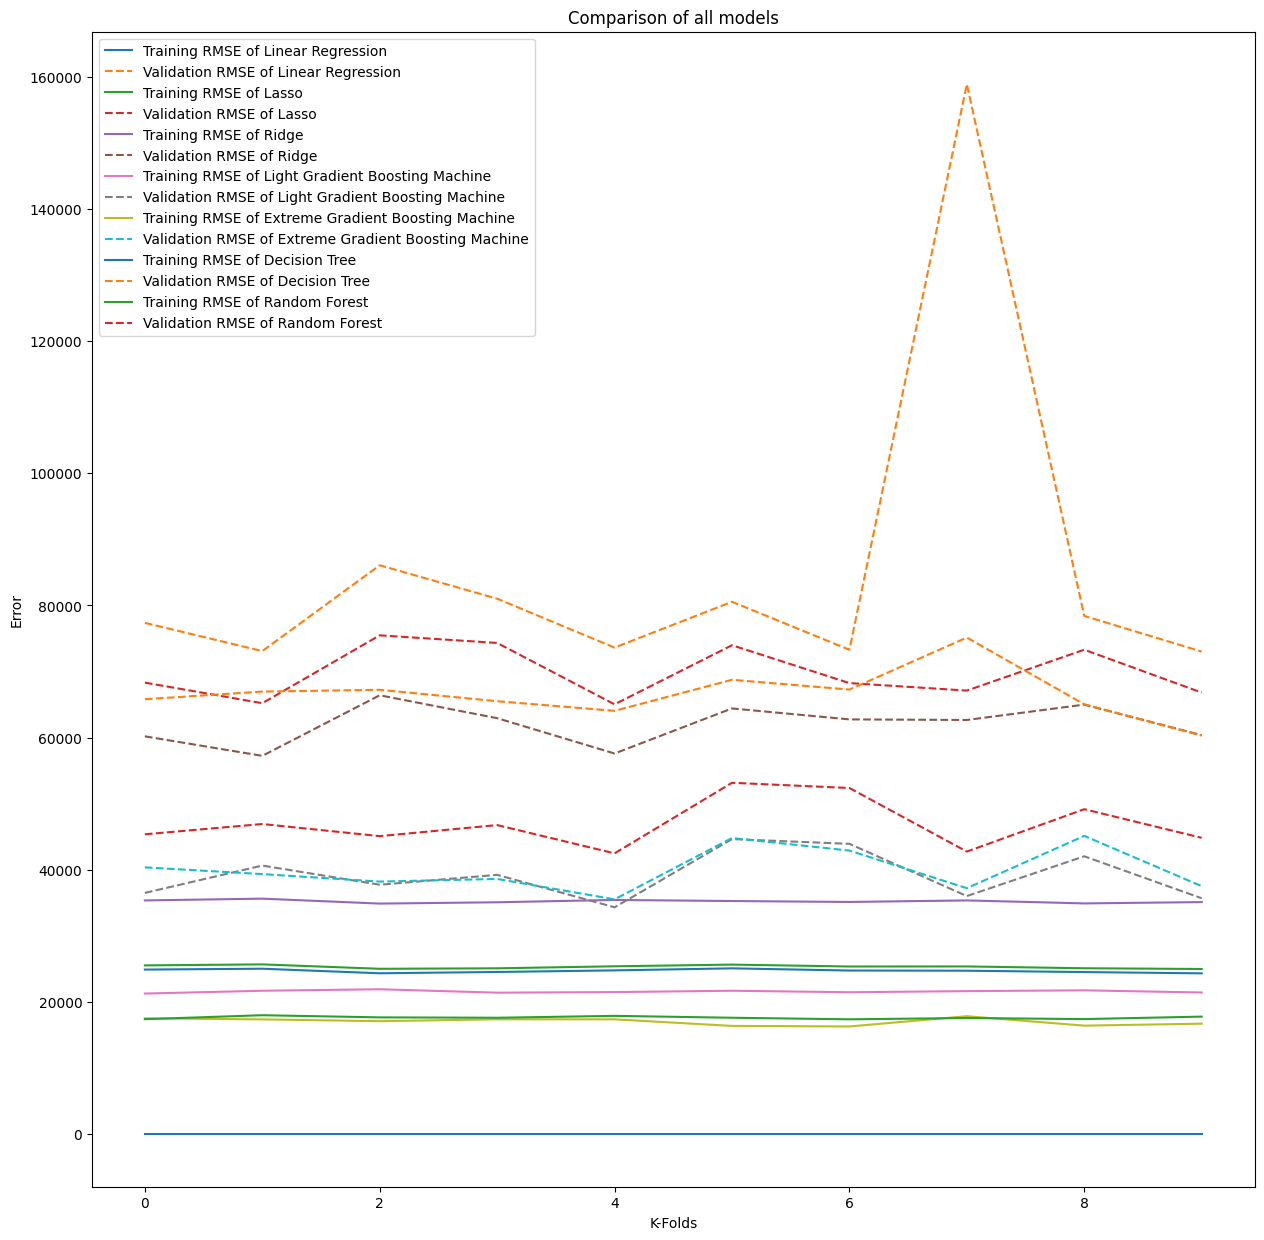

In [142]:
fig, ax = plt.subplots(figsize = (15,15))

for index, model_name in enumerate(model_list.keys()):
    
    train_rmse_list
    
    ax.plot(range(len(val_rmse_list[index])), ((-train_rmse_list[index])**(1/2)),label = 'Training RMSE of ' + model_name)
    ax.plot(range(len(val_rmse_list[index])), ((-val_rmse_list[index])**(1/2)), '--' , label = 'Validation RMSE of ' + model_name)

ax.set_title('Comparison of all models')
ax.set_xlabel('K-Folds')
ax.set_ylabel('Error')
ax.legend()
plt.show()

Apparently the better scores are from the ensemble models, namely the XGB and LGBM. The results are very comparable. This is to be expected.

In [143]:
# takes around 7 mins
params = {'max_bin': [300,350,400],
          'learning_rate': np.arange(0.1,0.5,0.2),
          'num_leaves': range(300,360,20),
         'random_state': [SEED]}

cv = 3

lgb = lgb.LGBMRegressor(random_state = SEED)

cv = GridSearchCV(lgb,param_grid = params, scoring = 'neg_mean_squared_error', cv=3)

lgb_cv = cv.fit(X_train_preprocessed, y_train)


print(lgb_cv.best_params_)

{'learning_rate': 0.1, 'max_bin': 350, 'num_leaves': 300, 'random_state': 42}


In [144]:
lgb_score = (-lgb_cv.best_score_)**(1/2)
print(lgb_score)

22752.095167383195


# Data Prep

List of configurable parameters:
- include or exclude features
- prediction algorithm

Functions
- Display Training, Validation scores, export training results with graph


List of all transformations done (to be done) on dataset:
- town : OHE
- flat_type : ordinal
- flat_model : OHE
- floor_area_sqm : standard scaling
- street_name : dropped
- resale_price : target, no change
- month : split into year and month with month overwritting column's values
- lease_commence_date : drop
- storey_range : Ordinal Encode
- block : dropped
- address : dropped
- remaining_lease : standard scaling
- full_address : dropped
- lat : standard scaling
- long : standard scaling
- nearest_mrt : OHE
- nearest_distance_to_mrt : standard scaling
- district : ohe or labelencoder

In [ ]:
train_df, test_df = train_test_split(df_combined_geo, test_size=TEST_SIZE, random_state=SEED)

In [ ]:
train_df.columns

In [ ]:
ordinal_ranking_flat_type = ['MULTI GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12','11 TO 15', '13 TO 15',
        '16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30',
       '31 TO 33','31 TO 35','34 TO 36',  '37 TO 39', '36 TO 40', '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

ORDINAL_FEATURES = ["storey_range", "flat_type"]
CAT_FEATURES = ["town", "nearest_mrt", "flat_model"]
NUM_FEATURES = ["remaining_lease","floor_area_sqm","month", "year", "lat", "long","nearest_distance_to_mrt"]
POSSIBLE_NA_FEATURES = ["postal_code"]
TARGET = "resale_price"

In [ ]:
class Conversion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['remaining_lease'] = X['remaining_lease'].astype(str).str[:2].astype(int)
        X['floor_area_sqm'] = X['floor_area_sqm'].astype(float)
        X['resale_price'] = X['resale_price'].astype(float)
        X['flat_type'] = X['flat_type'].str.replace('MULTI-GENERATION','MULTI GENERATION')
        return X

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, year:bool = True, month:bool = True,postal_code:bool = True) -> None:
        self.year = year
        self.month = month
        self.postal_code = postal_code
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.year:
            X['year'] = pd.to_datetime(X['month']).dt.year
        if self.month:
            X['month'] = pd.to_datetime(X['month']).dt.month
        if self.postal_code:
            X['postal_code'] = X['full_address'].apply(lambda x:x[-6:])
            X['postal_code'] = pd.to_numeric(X['postal_code'], errors='coerce')
            X['postal_code'].fillna(0, axis=0, inplace=True)
            X['postal_code'] = X['postal_code'].astype(int)
        return X

In [ ]:
ordinal_pipe = OrdinalEncoder(categories=[ordinal_ranking_storey_range,ordinal_ranking_flat_type])
cat_pipe = OneHotEncoder(drop='first', sparse=False)
num_pipe = StandardScaler()
convert_pipe = Conversion()
addfeature_pipe = AddFeatures()
simpleimputer = SimpleImputer(strategy="median")

column_pipe = ColumnTransformer([
    ('cat_pipe',cat_pipe , CAT_FEATURES),
    ('num_pipe',num_pipe, NUM_FEATURES),
    ('ordinal_pipe', ordinal_pipe, ORDINAL_FEATURES),
    ('imputer', simpleimputer, POSSIBLE_NA_FEATURES)
    ], remainder='drop')

add_features_pipe = Pipeline([
    ('add_features', addfeature_pipe),
    ('conversion', convert_pipe)
])

datapipe = Pipeline([
    ('add_features_conversion', add_features_pipe),
    ('column_transformer', column_pipe)
])

In [146]:
valid_list = {
    'model':['xgb','lgbm','lasso','linear_regression', 'ridge', 'elasticnet'],
    'dimension_reduction':['pca'],
    'clustering':['dbscan']
}

In [151]:
list(train_df.columns)

['town',
 'flat_type',
 'flat_model',
 'floor_area_sqm',
 'resale_price',
 'month',
 'storey_range',
 'remaining_lease',
 'full_address',
 'lat',
 'long',
 'nearest_mrt',
 'nearest_distance_to_mrt',
 'year',
 'district',
 'dbscan_label']

In [159]:
l1 = list(train_df.columns)
l2 = ['town','flat_type']

In [160]:
[x for x in l1 if x not in l2]

['flat_model',
 'floor_area_sqm',
 'resale_price',
 'month',
 'storey_range',
 'remaining_lease',
 'full_address',
 'lat',
 'long',
 'nearest_mrt',
 'nearest_distance_to_mrt',
 'year',
 'district',
 'dbscan_label']

In [154]:
np.array(train_df.columns) - np.array(['town','flat_type'])

ValueError: operands could not be broadcast together with shapes (16,) (2,) 

In [170]:
from typing import List, Union
import logging 

class modelpipeline:
    """
    A pipeline to take in a pandas dataframe and has some configurables 
    to tailor the model or how the data would be preprocessed
    """
    def __init__(
        self, 
        dataset:pd.DataFrame, 
        model:str,
        dimension_reduction:str,
        clustering:str,
        test_size:float=0.3,
        random_state:int=42,
        features_out:List[str] = ['street_name', 'lease_commence_date','block','address','full_address']
        ) -> None:
        self.dataset = dataset
        self.features_out = features_out
        self.model = model
        self.dimension_reduction = dimension_reduction
        self.clustering = clustering
        self.test_size = test_size
        self.random_state = random_state

        ordinal_ranking_flat_type = ['MULTI GENERATION','EXECUTIVE', '5 ROOM','4 ROOM', '3 ROOM','2 ROOM', '1 ROOM']
        ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', 
        '10 TO 12','11 TO 15', '13 TO 15','16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', 
        '25 TO 27', '26 TO 30', '28 TO 30','31 TO 33','31 TO 35','34 TO 36','37 TO 39', '36 TO 40', 
        '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

        ORDINAL_FEATURES = ["storey_range", "flat_type"]
        CAT_FEATURES = ["town", "nearest_mrt", "flat_model"]
        NUM_FEATURES = ["remaining_lease","floor_area_sqm","month", "year", "lat", "long","nearest_distance_to_mrt"]
        POSSIBLE_NA_FEATURES = ["postal_code"]
        TARGET = "resale_price"

        self.ordinal_pipe = OrdinalEncoder(categories=[ordinal_ranking_storey_range,ordinal_ranking_flat_type])
        self.cat_pipe = OneHotEncoder(drop='first', sparse=False)
        self.num_pipe = StandardScaler()
        self.convert_pipe = Conversion()
        self.addfeature_pipe = AddFeatures()
        self.simpleimputer = SimpleImputer(strategy="median")

        params_to_check = ['model','dimension_reduction','clustering']

        self.logger = logging.getLogger(__name__)

        # Check valid
        for item in params_to_check:
            if self._check_valid(item, f"{self.item}") == False:
                raise SyntaxError('Incorrect value')

        self.dimension_reduction_model = PCA(n_components=0.95)
        self.clustering_model = DBSCAN(eps=1.5)

    def _check_valid(self,type:str,value:str)->bool:
        """Checks if the parameter is valid

        Args:
            type (str): Accepts model, dimension_reduction or clustering
            value (str): the value of the param, i.e if its model, then xgb, lgbm, etc

        Returns:
            bool: If params are valid
        """
        valid_list = {
            'model':['xgb','lgbm','lasso','linear_regression', 'ridge', 'elasticnet'],
            'dimension_reduction':['pca'],
            'clustering':['dbscan']
        }
        return value in valid_list[type]
        
    def _add_year(self) -> None:
        """
        Adds the year feature into the dataset
        """
        try:
            self.dataset['year'] = pd.to_datetime(self.dataset['month']).dt.year
        except Exception as e:
            self.logger.critical(f"Unable to create year column due to error msg {e}")

    def _add_month(self) -> None:
        """
        Adds the month feature from the existing month column,
        overwriting it
        """
        try:
            self.dataset['month'] = pd.to_datetime(self.dataset['month']).dt.month
        except Exception as e:
            self.logger.critical(f"Unable to change month column due to error msg {e}")

    def _add_district(self) -> None:
        """
        Adds the district feature using the full_address column by taking
        the first 2 digits of the postal code in the full address. Fills na with 0
        """
        try:
            self.dataset['district'] = self.dataset['full_address'].apply(lambda x:x[-6:-4])
            self.dataset['district'] = pd.to_numeric(self.dataset['district'], errors='coerce')
            self.dataset['district'].fillna(0, axis=0, inplace=True)
            self.dataset['district'] = self.dataset['district'].astype(int)
        except Exception as e:
            self.logger.critical(f"Unable to add district column due to error msg {e}")
    
    def _add_features(self) -> None:
        """
        Adds all of the features
        """
        self._add_year()
        self._add_month()
        self._add_district()

    def _convert_features(self) -> None:
        """
        convert features from the dataset and replaces some text due to consistency issue
        """
        self.dataset['remaining_lease'] = self.dataset['remaining_lease'].astype(str).str[:2].astype(int)
        self.dataset['floor_area_sqm'] = self.dataset['floor_area_sqm'].astype(float)
        self.dataset['resale_price'] = self.dataset['resale_price'].astype(float)
        self.dataset['flat_type'] = self.dataset['flat_type'].str.replace('MULTI-GENERATION','MULTI GENERATION')
    
    def _drop_features(self)-> None:
        """
        Drops features
        """
        self.dataset.drop(columns=self.features_out, inplace=True)

    def _dimension_reduction(self)->pd.DataFrame:
        """
        Uses the selected dimension reduction technique and replaces the original features
        with them
        """
        pass

    def _clustering_feature(self)->None:
        """
        Adds clustering label as feature after reducing dimensions
        """
        dataset_dim_reduced = self.dimension_reduction_model.fit_transform(self.dataset)
        self.logger.info(list(zip(["pca " + str(idx) for idx in \
            range(1,len(self.dimension_reduction_model.explained_variance_ratio_))] ,
            self.dimension_reduction_model.explained_variance_ratio_)))
        self.clustering_model.fit(dataset_dim_reduced)

        labels = self.clustering_model.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        self.logger.info(f"Estimated number of clusters: {n_clusters_}")
        self.logger.info(f"Estimated number of noise points: {n_noise_}")

        self.dataset['clustering_label'] = labels

        pass

    def _pre_process(self)->None:
        """
        Prepares the dataset by adding, dropping, transforming features before
        splitting and training
        """

        # drops features before adding
        if len(self.features_out) !=0:
            self._drop_features()
        
        self._add_features()
        
        if self.dimension_reduction:
            self._dimension_reduction()
        
        if self.clustering:
            self._clustering_feature()
        

    def _transform(self, dataset) -> np.array:
        """
        transforms the dataset by using the datapipe
        """
        dataset_transformed = self.datapipe.transform(dataset)

        return dataset_transformed

    def _fit(self, dataset)-> None:
        """
        Fits the datapipe with the dataset
        """
        self.column_pipe = ColumnTransformer([
            ('cat_pipe',cat_pipe , CAT_FEATURES),
            ('num_pipe',num_pipe, NUM_FEATURES),
            ('ordinal_pipe', ordinal_pipe, ORDINAL_FEATURES),
            ('imputer', simpleimputer, POSSIBLE_NA_FEATURES)
            ], remainder='drop')

        self.add_features_pipe = Pipeline([
            ('add_features', addfeature_pipe),
            ('conversion', convert_pipe)
        ])

        self.datapipe = Pipeline([
            ('add_features_conversion', add_features_pipe),
            ('column_transformer', column_pipe)
        ])

        self.datapipe.fit(dataset)
    

    def fit_transform(self, dataset)-> np.array:
        """
        Fits and transforms the dataset with the datapipe
        """
        self._fit()
        dataset_transformed = self._transform(dataset)

        return dataset_transformed

    def train(self, full_set:bool = True)->None:
        """
        Trains the model
        """

        ############################################################
        # preps the dataset, adding, dropping features , etc
        ############################################################
        self._pre_process()

        ##############################
        # Seperates X and y
        ##############################
        y = self.dataset.resale_price
        X = self.dataset.loc[:, train_df.columns != 'resale_price'] 

        if full_set == False:
            X, X_test, y, y_test= train_test_split(X, y,test_size=self.test_size, random_state=self.random_state)
            self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_test, y_test,test_size=0.5, random_state=self.random_state)
        
        self.X_train = X
        self.y_train = y

        X_transformed = self.fit_transform(X)
        self.logger.info(f"Shape of X transformed training set: {X_transformed.shape}")

        self.model.fit(X_transformed, y)

    def report_metrics(self, X, y)->dict:
        """
        Returns metrics for the chosen model in a dictionary
        """
        cv = 10
        model_cv_score = cross_validate(self.model,X, y, scoring = 'neg_mean_squared_error', 
        cv=cv, n_jobs = -1,return_train_score= True )
        
        train_rmse_list.append(model_cv_score['train_score'])
        val_rmse_list.append(model_cv_score['test_score'])
        
        metrics = {
            'Model': self.model,
            'Mean Train RMSE': ((-model_cv_score['train_score'])**(1/2)).mean(),
            'Train RMSE': list(model_cv_score['train_score']),
            'Val RMSE' : list(model_cv_score['test_score']),
            'Mean Val RMSE': ((-model_cv_score['test_score'])**(1/2)).mean()
        }

        return metrics

    def report_best_features(self)->dict:
        """
        Returns a dictionary with the best features and its importance
        Using model's inbuilt feature or Lasso if unavailable 
        """
        pass


    def tune(self, params:dict)-> None:
        """
        Perform hyperparameter tunning for the model
        """
        pass

    def predict(self, inputs)-> Union[float,List[float]]:
        """
        Using the model to predict either batch or single data
        Returns either a list of predictions or a single prediction
        """
        pass


In [ ]:
datapipe = Data

# Modelling

In [ ]:
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, year:bool = True, month:bool = True,postal_code:bool = True) -> None:
        self.year = year
        self.month = month
        self.postal_code = postal_code
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.year:
            X['year'] = pd.to_datetime(X['month']).dt.year
        if self.month:
            X['month'] = pd.to_datetime(X['month']).dt.month
        if self.postal_code:
            X['postal_code'] = X['full_address'].apply(lambda x:x[-6:])
            X['postal_code'] = pd.to_numeric(X['postal_code'], errors='coerce')
            X['postal_code'].fillna(0, axis=0, inplace=True)
            X['postal_code'] = X['postal_code'].astype(int)
        return X

class Conversion(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['remaining_lease'] = X['remaining_lease'].astype(str).str[:2].astype(int)
        X['floor_area_sqm'] = X['floor_area_sqm'].astype(float)
        return X

class DataPipeline_test():

    def __init__(self, addfeature:bool = True,seed:int=42,test_size:float=0.33):
        self.test_size = test_size
        self.seed = seed
        self.ORDINAL_FEATURES = ["storey_range"]
        self.CAT_FEATURES = ["town", "nearest_mrt", "flat_model","flat_type"]
        self.NUM_FEATURES = ["remaining_lease","floor_area_sqm","month", "year",\
             "lat", "long", "postal_code","nearest_distance_to_mrt"]
        self.TARGET = "resale_price"
        self.POSSIBLE_NA_FEATURE = ["postal_code"]
        self.ordinal_ranking_storey_range = [ '01 TO 03','01 TO 05','04 TO 06', '06 TO 10', '07 TO 09', '10 TO 12','11 TO 15', '13 TO 15',
        '16 TO 18','16 TO 20','19 TO 21','21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30', '28 TO 30',
       '31 TO 33','31 TO 35','34 TO 36',  '37 TO 39', '36 TO 40', '40 TO 42', '43 TO 45', '46 TO 48','49 TO 51']

        self.ordinal_pipe = OrdinalEncoder(categories=[self.ordinal_ranking_storey_range])
        self.cat_pipe = OneHotEncoder(drop='first', sparse=False)
        self.num_pipe = StandardScaler()
        self.convert_pipe = Conversion()
        self.addfeature_pipe = AddFeatures()
        self.simpleimputer = SimpleImputer(strategy="median")

        if addfeature==False:
            self.NUM_FEATURES.remove('postal_code')
            self.NUM_FEATURES.remove('year')

        column_pipe = ColumnTransformer([
            ('cat_pipe',self.cat_pipe , self.CAT_FEATURES),
            ('num_pipe',self.num_pipe, self.NUM_FEATURES),
            ('ordinal_pipe', self.ordinal_pipe, self.ORDINAL_FEATURES)
            ], remainder='drop')

        add_features_pipe = Pipeline([
            ('add_features', self.addfeature_pipe),
            ('conversion', self.convert_pipe)
        ])

        if addfeature:
            self.datapipe = Pipeline([
                ('add_features_conversion', add_features_pipe),
                ('column_transformer', column_pipe)
            ]) 

        else:
            self.datapipe = Pipeline([
                ('conversion', self.convert_pipe),
                ('column_transformer', column_pipe)
            ]) 

    def _split(self, df:pd.DataFrame):
        y = df.pop(self.TARGET)
        X = df


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, \
            random_state=self.seed)

        return X_train, X_test, y_train, y_test

    def _run_ct(self, X_train, X_test):
        X_train = self.datapipe.fit_transform(X_train)
        X_test = self.datapipe.transform(X_test)

        return X_train, X_test

    def transform(self, df, y= None):
        """preprocess, transform and then split the dataset

        Parameters
        ----------
        X : pd.DataFrame
            the entire DataFrame
        y : None, Ignored
        """
        X_train, X_test, y_train, y_test = self._split(df)

        X_train, X_test = self._run_ct(X_train, X_test)

        return X_train, X_test, y_train, y_test


In [ ]:
df_original_copy  = df_original.copy()

In [ ]:
datapipeline = DataPipeline_test()
X_train, X_test, y_train, y_test = datapipeline.transform(df_original_copy)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.datapipeline import DataPipeline

df_original_copy_2 = df_original.copy()

datapipeline = DataPipeline()
X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = datapipeline.transform(df_original_copy_2)

In [ ]:
# Check to see if the datapipeline yields the same results

In [ ]:
np.array_equal(X_train, X_train_pipe)

In [ ]:
np.array_equal(X_test, X_test_pipe)

In [ ]:
np.array_equal(y_train, y_train_pipe)

In [ ]:
np.array_equal(y_test, y_test_pipe)

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = (mse)**(1/2)

print(rmse)

In [ ]:
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor(), DecisionTreeRegressor()]

In [ ]:
dict_results = {}

def train_model(model, X_train:np.array, y_train:np.array, X_test:np.array, y_test:np.array):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = (mse)**(1/2)

    print(f"Model used is {model}")
    print(f"Rmse is {rmse}")
    print(f"Mae is {mae}")
    return model, rmse , mae

In [ ]:
for model in models:
    model_fit, rsme, mae = train_model(model, X_train, y_train, X_test, y_test)
    dict_results[model] = {'fitted model':model_fit, 'RMSE': rmse, 'MAE': mae}

In [ ]:
# Second Iteration / Feature Selection II